### Multi dimensional scaling and spatial interpolation for NorthEuraLex data ###
---
**The task at hand**  

The database at http://northeuralex.org/ contains lexical data for ca. 100 languages from Northern Eurasia.

1. Compute pairwise distances between these languages. (You may use the Python library https://lingpy.org/ for this.)  

2. Apply Multi-Dimensional Scaling to these distances and extract the 3 most important dimensions.  

3. Using spatial interpolation, visualize these dimensions on a map. 
---


To start, the working directory is set and the necessary libraries are loaded

In [1]:
# set working directory
setwd("C:/Users/stein/Dropbox/Studium/7. Semester/Languages in Space/Project")

# load libraries
library(gstat)
library(sf)
library(spData)
library(terra)
library(tidyverse)
library(tmap)

Warning message:
"Paket 'gstat' wurde unter R Version 4.1.3 erstellt"
Linking to GEOS 3.9.1, GDAL 3.2.1, PROJ 7.2.1

terra version 1.4.11

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x tidyr::extract() masks terra::extract()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x dplyr::src()     masks terra::src()

Warning message:
"Paket 'tmap' wurde unter R Version 4.1.2 erstellt"


The NorthEuraLex database "covers a list of 1,016 concepts across 107 languages of Northern Eurasia" (Dellert & Jäger). The data can be downloaded directly from the NorthEuraLex website.

In [2]:
conceptdata_loc = "northeuralex-0.9-forms.tsv"
geodata_loc = "northeuralex-0.9-language-data.tsv"

if(!file.exists(conceptdata_loc)) {
    download.file(
        "http://www.sfs.uni-tuebingen.de/~jdellert/northeuralex/0.9/northeuralex-0.9-forms.tsv",
        dest = conceptdata_loc
    )
}

if(!file.exists(geodata_loc)) {
    download.file(
        "http://www.sfs.uni-tuebingen.de/~jdellert/northeuralex/0.9/northeuralex-0.9-language-data.tsv",
        dest = geodata_loc
    )
}

The first of the two downloaded tsv-files contains the concepts with the translations in each language - this includes IPA transcription and additional information. The second one gives - among other things - coordinates for each language, which can be used to map the results of the multi-dimensional scaling later. 

In [3]:
conceptdata = read_tsv("northeuralex-0.9-forms.tsv")
geodata = read_tsv("northeuralex-0.9-language-data.tsv")

Rows: 121613 Columns: 10

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr (10): Language_ID, Glottocode, Concept_ID, Word_Form, rawIPA, IPA, ASJP,...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 107 Columns: 7

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr (5): name, glotto_code, iso_code, family, subfamily
dbl (2): latitude, longitude


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Upon inspection of the data, there seems to be a parsing issue.

In [4]:
conceptdata

Warning message:
"One or more parsing issues, see `problems()` for details"


Language_ID,Glottocode,Concept_ID,Word_Form,rawIPA,IPA,ASJP,List,Dolgo,Next_Step
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
fin,finn1318,Auge::N,silmä,silmæ,s i l m æ,silmE,SILME,SVRMV,validate
fin,finn1318,Ohr::N,korva,k<U+0254>r<U+028B><U+0251>,k <U+0254> r <U+028B> <U+0251>,korwa,KURWA,KVRWV,validate
fin,finn1318,Nase::N,nenä,n<U+025B>næ,n <U+025B> n æ,nEnE,NENE,NVNV,validate
fin,finn1318,Mund::N,suu,su<U+02D0>,s u u,su,SY,SV,validate
fin,finn1318,Zahn::N,hammas,h<U+0251>m<U+02D0><U+0251>s,h <U+0251> m m <U+0251> s,hamas,HAMAS,HVMVS,validate
fin,finn1318,Zunge::N,kieli,ki<U+025B><U+032F>li,k i <U+025B> l i,kiEli,KIELI,KVRV,validate
fin,finn1318,Lippe::N,huuli,hu<U+02D0>li,h u u l i,huli,HYLI,HVRV,validate
fin,finn1318,Wange::N,poski,p<U+0254>ski,p <U+0254> s k i,poski,PUSKI,PVSKV,validate
fin,finn1318,Gesicht::N,naama,n<U+0251><U+02D0>m<U+0251>,n <U+0251> <U+0251> m <U+0251>,nama,NAMA,NVMV,validate


Calling _problems()_ helps to find the cell that caused the issues.

In [5]:
problems()
conceptdata$Next_Step[85357]

row,col,expected,actual,file
<int>,<int>,<chr>,<chr>,<chr>
85358,19,10 columns,19 columns,C:/Users/stein/Dropbox/Studium/7. Semester/Languages in Space/Project/northeuralex-0.9-forms.tsv


[1] "validate\tnull\tAuge::N\t<U+043D><U+044E><U+0434><U+044D><U+043D>\tnjud<U+025B><U+014B>\tn j u d <U+025B> <U+014B>\tnyudEN\tNJYTEN\tNJVTVN\tvalidate"

Since only 3 of the columns are needed, they can be selected and the one row that got stuck in the _Next_Step_ column of row #85357 is added afterwards.

In [6]:
conceptdata = 
    conceptdata %>% 
    # select the 3 relevant columns
    select(Language_ID, Concept_ID, ASJP) %>%
    # add the missing row
    add_row(Language_ID = "xal", Concept_ID = "Auge::N", ASJP = "nyudEN")

Why only these 3 columns? The _Language_ID_ column is necessary to identify which language each row belongs to. Then, the _Concept_ID_ column can be used to compare the words for specific concepts between languages. Lastly there's the _ASJP_ column. To explain why that column is used and not - e.g. - the IPA column, it helps to look at the computations necessary to calculate the distances between the 107 languages. 

The number of comparisons for 107 languages is given by the sum of consecutive integers starting from *m=1* and ending with *n=106*. With the formula *(m * m + 1) / 2* the result can be calculated: 5671. If all 1016 concepts are compared for each language pair, roughly (5671 * 1016 =) **5.761.736** distances between words would have to be computed. The actual number of comparisons would be even higher since many languages have multiple words for some of the concepts. 

To simplify this a bit, it is possible to instead focus on a smaller set of concepts, given by the **ASJP (Automated Similarity Judgment Program) wordlist**. This list is derived from the longer Swadesh list (Swadesh, 1955) by simply choosing the 40 most stable concepts (Holman et al., 2008). These word list serve as a way to compare languages effectively, as Holman et al. note that comparing too many concepts can in fact even lower the accuracy of the distances (2008). This is due to the fact that choosing more concepts introduces less stable concepts to the mix. And the less stable a concept is, the more likely it is, that the corresponding word in each language is replaced by a different word, which dilutes the accuracy of the distances. 

Instead of using the IPA transcriptions to calculate the Levenshtein distance, the ASJPcodes (the ASJP column in the _conceptdata_) of the words are used.  An ASJPcode - brought forward by Brown et al. (2008) - is a simplification of a word's IPA transcription that only uses letters from a QWERTY keyboard (Holman et al., 2008). Therefore it ignores some things like tone or stress of vowels, and replaces some rare segments with more common ones that are similar (Holman et al., 2008).

To implement this, a list of all the concepts on the ASJP wordlist is created, and then the _conceptdata_ can be filtered to only include concepts on the list.

In [7]:
# create ASJP word list
asjp_concepts = c("Auge::N", "Ohr::N", "Nase::N", "Zahn::N", "Zunge::N",
                  "Busen::N", "Hand::N", "Knie::N", "Haut::N", "Blut::N", 
                  "Knochen::N", "Leber::N", "Sonne::N", "Stern::N", "Wasser::N",
                  "Stein::N", "Feuer::N", "Berg::N", "Baum::N", "Blatt::N",
                  "Horn::N", "Hund::N", "Fisch::N", "Laus::N", "Mensch::N", 
                  "Name::N", "Pfad::N", "Nacht::N", "voll::A", "neu::A", 
                  "ich::PRN", "du::PRN", "wir::PRN", "eins::NUM", "zwei::NUM",
                  "trinken::V", "sterben::V", "kommen::V", "sehen::V", 
                  "hören::V")
# filter out other concepts
conceptdata = filter(conceptdata, Concept_ID %in% asjp_concepts)

From the tibble with the coordinates, a tibble of the 107 languages can be made by simply selecting the _iso_code_ column.

In [8]:
languages = 
    geodata %>% select(iso_code)

Now a list containing 107 tibbles - one for each language - can be built.

In [9]:
# make a list
language_params = list()
# loop through all the languages
for (i in 1:nrow(languages)) {
    lang = 
        conceptdata %>%
        filter(Language_ID == languages$iso_code[i]) %>%
        select(Concept_ID, ASJP)
    language_params[[i]] = lang
}
# take a look at one of the tibbles
language_params[42]

Concept_ID,ASJP
<chr>,<chr>
Auge::N,oko
Ohr::N,wuxo
Nase::N,nis
Zahn::N,zub
Zunge::N,yazik
Busen::N,hrudi
Hand::N,ruka
Knie::N,kolino
Haut::N,Skira


Then it is time to calculate the pairwise distances between the languages. Therefore an empty matrix with 107 rows and columns is created.

In [10]:
# initalize empty matrix to store the distances
levenshtein_distances = 
    matrix(1, nrow(languages), nrow(languages))

To fill the matrix it is necessary to iterate over all language pairs and compute the distance between the languages in each pair. This language distance is calculated by taking the average of the 40 concept distances (if a language has no word for one or more of the 40 concepts, then the concept is simply skipped).  

A concept distance is represented by the Levenshtein distance between the words for the concept in each language. If a language has multiple words for a concept, then the distances for all of these words to the word of the other language are computed and the average of these distances serves as the concept distance.

In [11]:
# iterate through all pairs of languages
for (i in 1:(nrow(languages) - 1)) {
    for (j in (i + 1):nrow(languages)) {
        # create a language_pair tibble by joining two language tibbles of the list of tibbles created earlier
        pair = inner_join(language_params[[i]], language_params[[j]], 
                          by=c("Concept_ID" = "Concept_ID"))
        language_distance = 0
        k = 1
        n_concepts = 40
        # track if a concept needs to be skipped, because one of the languages has no word for it
        remove_concept = TRUE
        # loop over the 40 concepts
        for (concept in asjp_concepts) {
            n_pairs = 0
            concept_distance = 0
            while ((pair$Concept_ID[k] == concept) && k != nrow(pair) + 1) {
            remove_concept = FALSE
            n_pairs = n_pairs + 1
            concept_distance = 
              concept_distance +
              # calculate the Levenshtein distance of one word pair
              (adist(pair$ASJP.x[k], pair$ASJP.y[k]) /
                 max(nchar(pair$ASJP.x[k]), nchar(pair$ASJP.y[k])))
            k = k + 1
            }
            if (remove_concept) {n_concepts = n_concepts - 1} 
            else {
                remove_concept = TRUE
                # divide the concept distance by the number of word pairs
                # --> important when languages have more than one word for a concept
                concept_distance = concept_distance / n_pairs
                # increment the distance between the languages
                language_distance = language_distance + concept_distance
            }
        counter = 0
        concept_distance = 0
    }
    # get the distance between the two languages by dividing by the number of compared concepts (not always 40)
    levenshtein_distances[i, j] = (language_distance / n_concepts) 
    levenshtein_distances[j, i] = (language_distance / n_concepts)
  }
}
levenshtein_distances

1.0000000,0.1523958,0.2338393,0.3780804,0.3563393,0.4253571,0.7015179,0.7865476,0.7375298,0.7313690,...,0.9593452,0.9366541,0.8909646,0.8789683,0.8865774,0.8913568,0.9344318,0.9045238,0.9333333,0.8645238
0.1523958,1.0000000,0.1882292,0.3510937,0.3100595,0.4183780,0.6931696,0.7638393,0.7162798,0.7077083,...,0.9543452,0.9381422,0.8933761,0.8996763,0.8906250,0.8986485,0.9406818,0.8997917,0.9308333,0.8705208
0.2338393,0.1882292,1.0000000,0.3071875,0.3423958,0.4350744,0.7143155,0.7775893,0.7323363,0.7226786,...,0.9704167,0.9271303,0.8970085,0.8897661,0.8835417,0.8981871,0.9360606,0.8983333,0.9222917,0.8580208
0.3780804,0.3510937,0.3071875,1.0000000,0.3104911,0.4123735,0.7226488,0.8238393,0.7804911,0.7613244,...,0.9577083,0.9345865,0.8918803,0.9128342,0.9180208,0.9408211,0.9498106,0.9008333,0.9220833,0.8935417
0.3563393,0.3100595,0.3423958,0.3104911,1.0000000,0.4155952,0.7533631,0.8009226,0.7551190,0.7425000,...,0.9495833,0.9158835,0.8749084,0.8811612,0.8892857,0.9175373,0.9391937,0.8901190,0.9209821,0.8660119
0.4253571,0.4183780,0.4350744,0.4123735,0.4155952,1.0000000,0.7227381,0.8047917,0.7763690,0.7606250,...,0.9261310,0.9425752,0.9128816,0.8980576,0.9153571,0.9217437,0.9422294,0.8996429,0.9288095,0.8950000
0.7015179,0.6931696,0.7143155,0.7226488,0.7533631,0.7227381,1.0000000,0.6496429,0.6163988,0.6375298,...,0.9474405,0.9371867,0.9537851,0.9085840,0.9181845,0.8906810,0.9351975,0.9146131,0.8930357,0.9103274
0.7865476,0.7638393,0.7775893,0.8238393,0.8009226,0.8047917,0.6496429,1.0000000,0.4164583,0.5729762,...,0.9190774,0.9171992,0.9352259,0.8859023,0.9043899,0.8897882,0.9330952,0.8727530,0.8841667,0.9324107
0.7375298,0.7162798,0.7323363,0.7804911,0.7551190,0.7763690,0.6163988,0.4164583,1.0000000,0.3526488,...,0.9216667,0.9145990,0.9113553,0.8884085,0.9008333,0.8888743,0.9435011,0.9001190,0.8957143,0.9172619
0.7313690,0.7077083,0.7226786,0.7613244,0.7425000,0.7606250,0.6375298,0.5729762,0.3526488,1.0000000,...,0.9401786,0.9194862,0.9533272,0.8769424,0.8986458,0.8721096,0.9407089,0.9253869,0.9035714,0.9258929
0.7896429,0.7563690,0.7686905,0.8124405,0.7651190,0.7629167,0.6729762,0.5426190,0.4686310,0.4693155,...,0.8841071,0.9290727,0.9505495,0.8523183,0.9130952,0.8877048,0.9283117,0.8591071,0.9041369,0.9272024


With the matrix filled, the multi-dimensional scaling can be applied next.

In [12]:
# multi-dimensional scaling with 3 dimensions on the pairwise distance matrix
multi_dimensional_scaling = 
    cmdscale(levenshtein_distances, k=3) %>%
    as_tibble()

Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated."


To visualize the three dimensions on a map, each of them are scaled between 0 and 1 (by subtracting the minimum value of each dimension from each value in that dimension and then dividing each value by the maximum value of its dimension) and then combined into a color code (where the 3 dimensions represent red, green and blue respectively).

In [13]:
mds = 
    as_tibble(multi_dimensional_scaling) %>%
    mutate(languages = languages$iso_code) %>%
    # subtract the smallest value
    mutate(x = V1 - min(.$V1), y = V2 - min(.$V2), z = V3 - min(.$V3)) %>%
    # divide by maximum value
    mutate(r = x / max(.$x), g = y / max(.$y), b = z / max(.$z)) %>%
    # combine r, g, and b into a color
    mutate(col = rgb(r,g,b)) %>%
    # select the only two relevant columns
    select(languages, col, r, g, b) 

Next this color data is joined with the language coordinates from the *geodata* tibble.

In [14]:
# join coordinates with the color data 
geodata = geodata %>% 
    rename(languages = iso_code) %>%
    select(languages, latitude, longitude) %>%
    inner_join(mds)

Joining, by = "languages"



The new tibble is then plotted on a world map.

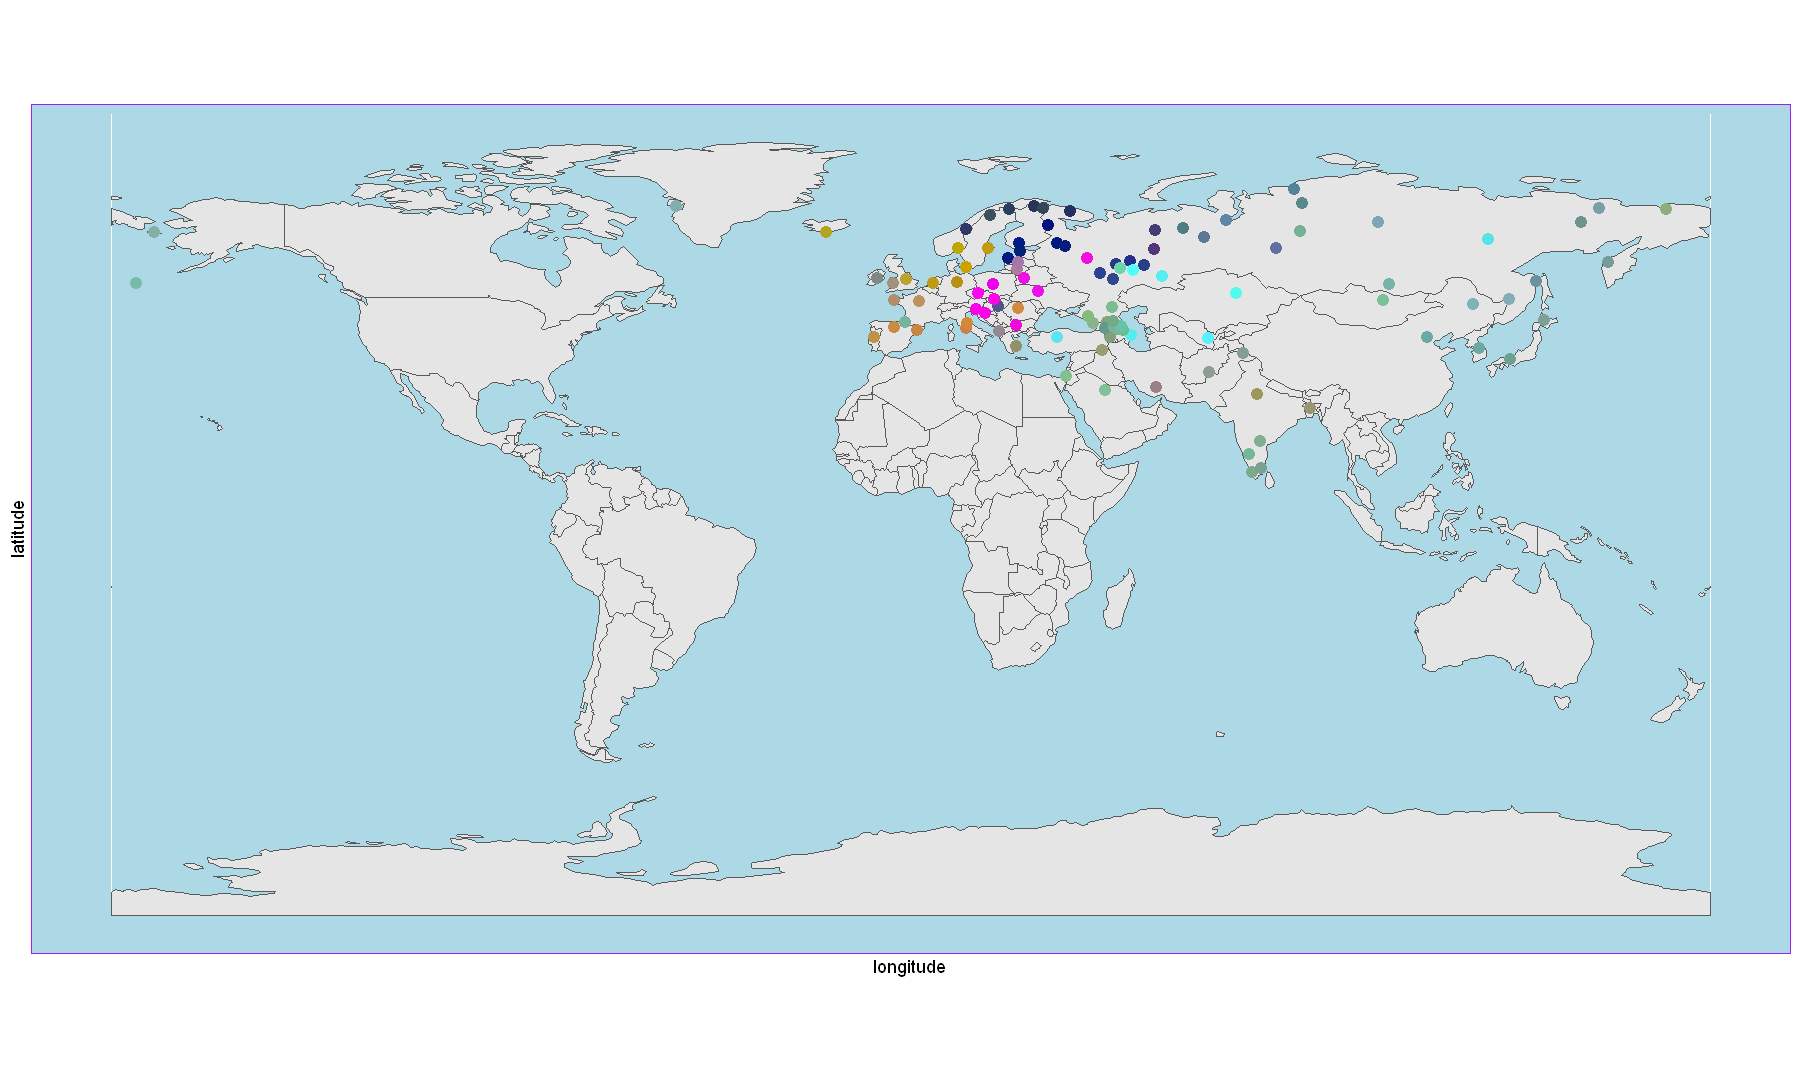

In [15]:
options(repr.plot.width=15, repr.plot.height=9)
world %>%
  ggplot() +
  geom_sf() +
  geom_point(data=geodata, aes(x=longitude, y = latitude), col=geodata$col, size=3) +
  theme(panel.background = element_rect(fill = 'lightblue', color = 'purple'))

Since the data at hand only deals with Eurasian languages it seems sensible to move the central meridian to avoid two lone languages being on the left side hand of the map. Therefore a slim polygon is cut from the world (necessary to avoid visually stretched polygons) and then the world is projected using the **equal earth projection** with 125°E as the central meridian. This projection is chosen, because spatial interpolation, that is applied later, is more accurate when the used map is equal-area (which the original equirectangular projection is not). 

In [16]:
# produce an extremely slim polygon that represents the 60° W meridian
meridian_60_west = 
    st_polygon(x = list(rbind(c(-55.0001, 90), # upper left corner of the polygon
                              c(-55, 90), # upper right corner of the polygon
                              c(-55, -90), # lower right corner of the polygon
                              c(-55.0001, -90), # lower left corner of the polygon
                              c(-55.0001, 90)))) %>%
    st_sfc() %>%
    # set the crs of the polygon to the geodetic system for world
    st_set_crs(4326)

world_without_55 = 
    world %>%
    # remove everything on the 60° meridian from the world data, effectively cutting all polygons that cross the meridian
    st_difference(meridian_60_west) %>%
    # project & move central meridian
    st_transform("+proj=eqearth lon_0=125")

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


Analogue to the world data, the coordinates in *geodata* are also projected.

In [17]:
# convert the coordinates in geodata into simple features
geodata_sf = 
    geodata %>%
    st_as_sf(coords=c("longitude", "latitude"), crs=4326) %>%
    # project & move central meridian
    st_transform("+proj=eqearth lon_0=125")

All of this allows for a more specific plot, that only focuses on the region of the world map where the languages in the dataset lie. The angular distortion of the countries is a consequence of the equal earth projection.   

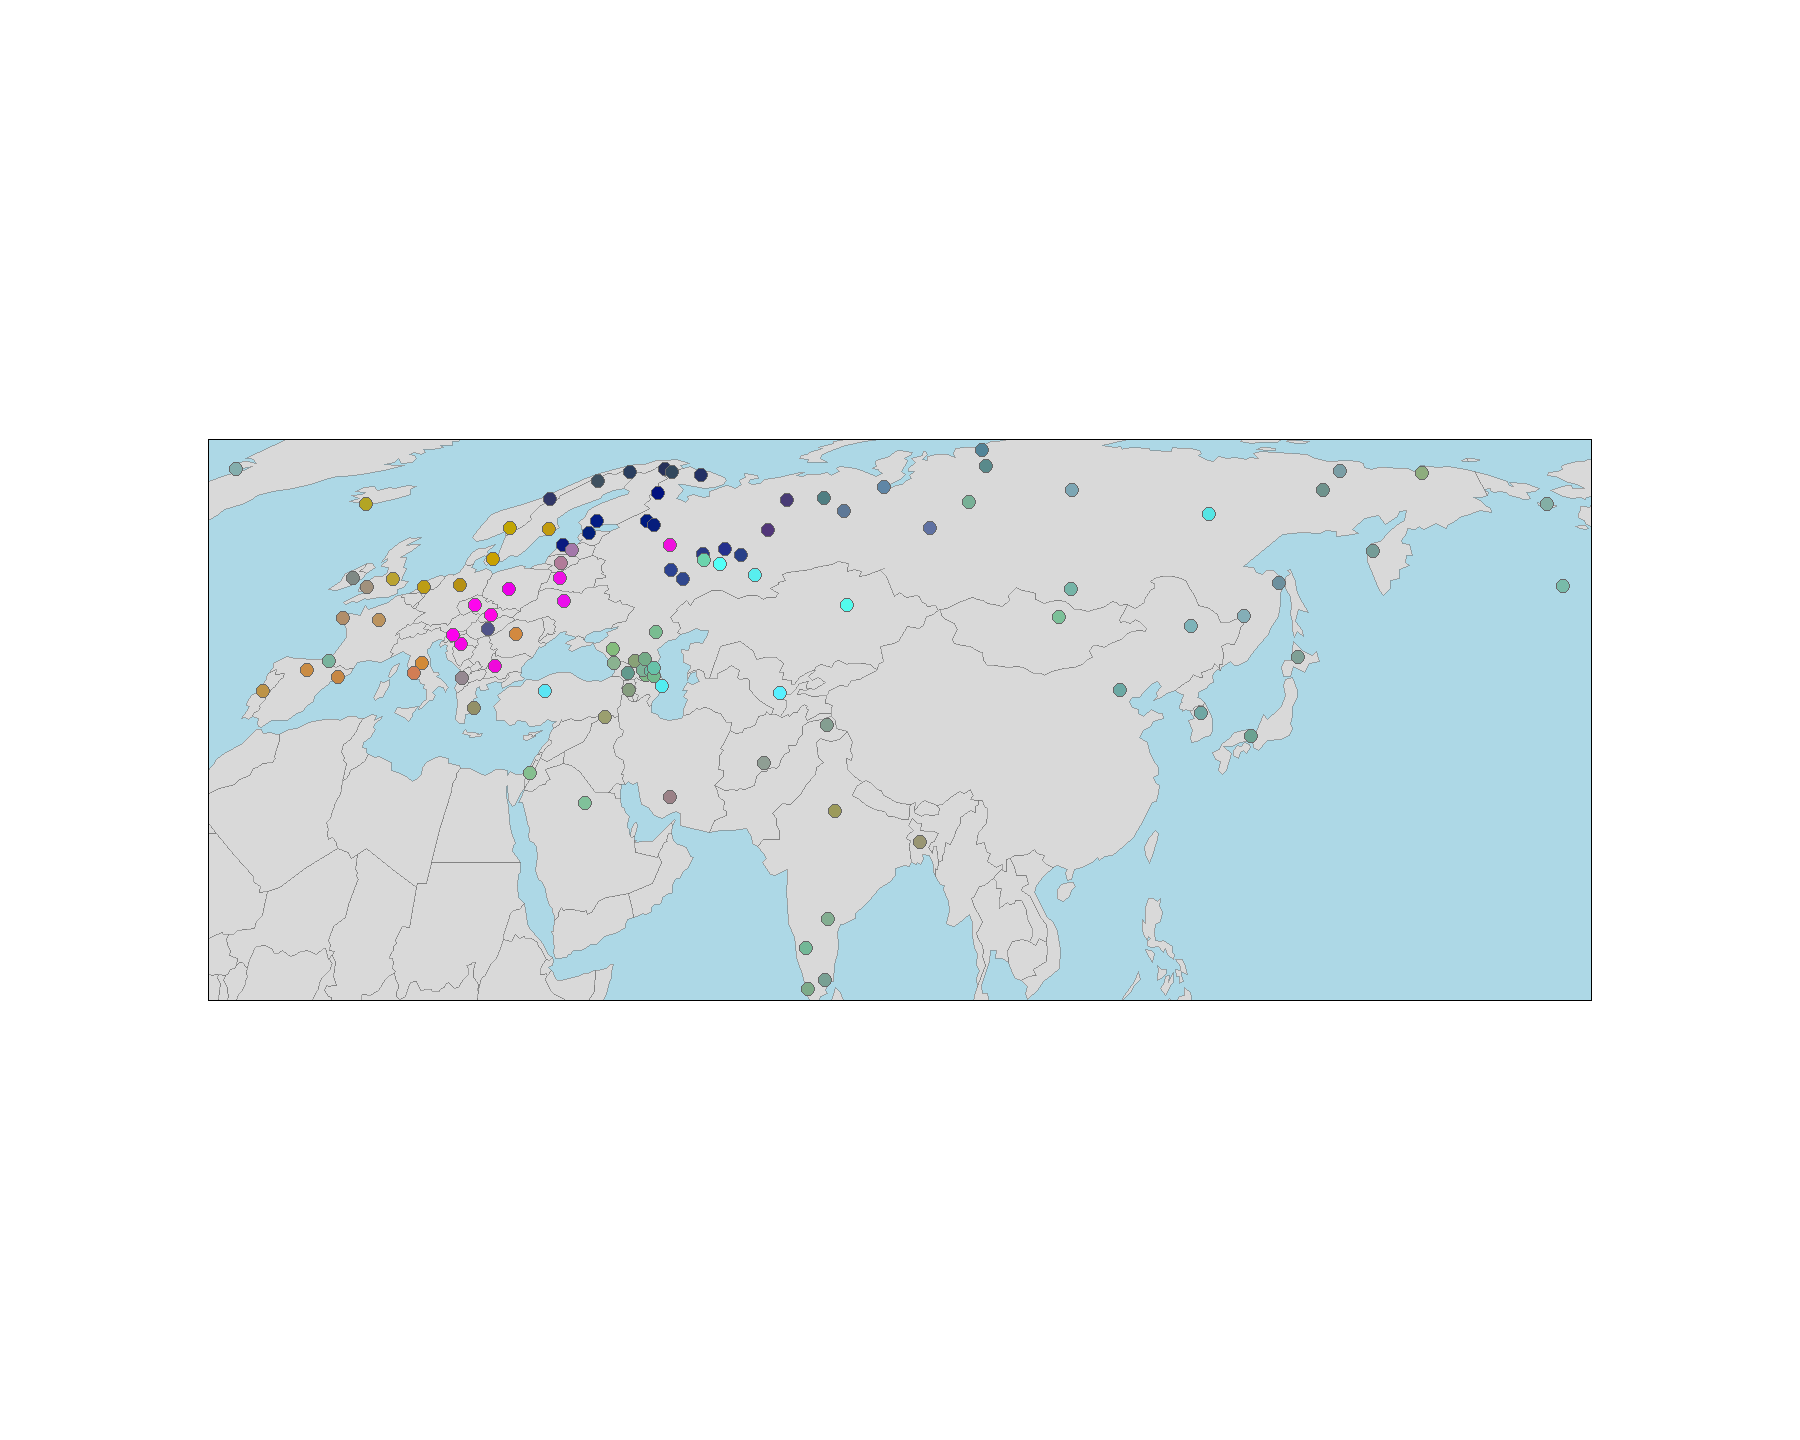

In [18]:
options(repr.plot.width=15, repr.plot.height=12)
geodata_sf %>%
    tm_shape() +
    tm_symbols(size=0.6, col="col", border.lwd=1, alpha=1) +
    tm_layout(bg.color = "lightblue") +
    tm_shape(world_without_55) +
    tm_polygons(alpha=1, border.alpha = 0.5) + 
    tm_shape(geodata_sf) +
    tm_symbols(size=0.6, col="col", border.lwd=1, alpha=1)

___
___
The final remaining task is to use spatial interpolation to visualize the three dimensions on the whole map and not just on the language points. The first step to achieve this, is the creation of a grid based on the *geodata_sf* tibble. The cellsize of the grid is chosen via trial & error to achieve a balance of runtime & resolution.

In [19]:
world_grid = 
    geodata_sf %>% 
    # get the rectangle which contains all of the geodata_sf language points
    st_bbox() %>%
    st_as_sfc() %>%
    # create a grid based on that rectangle
    st_make_grid(
        cellsize = c(15000, 15000),
        what="centers"
    )

The chosen interpolation method is ordinary kriging. Therefore a look at the variogram of the language points is necessary.

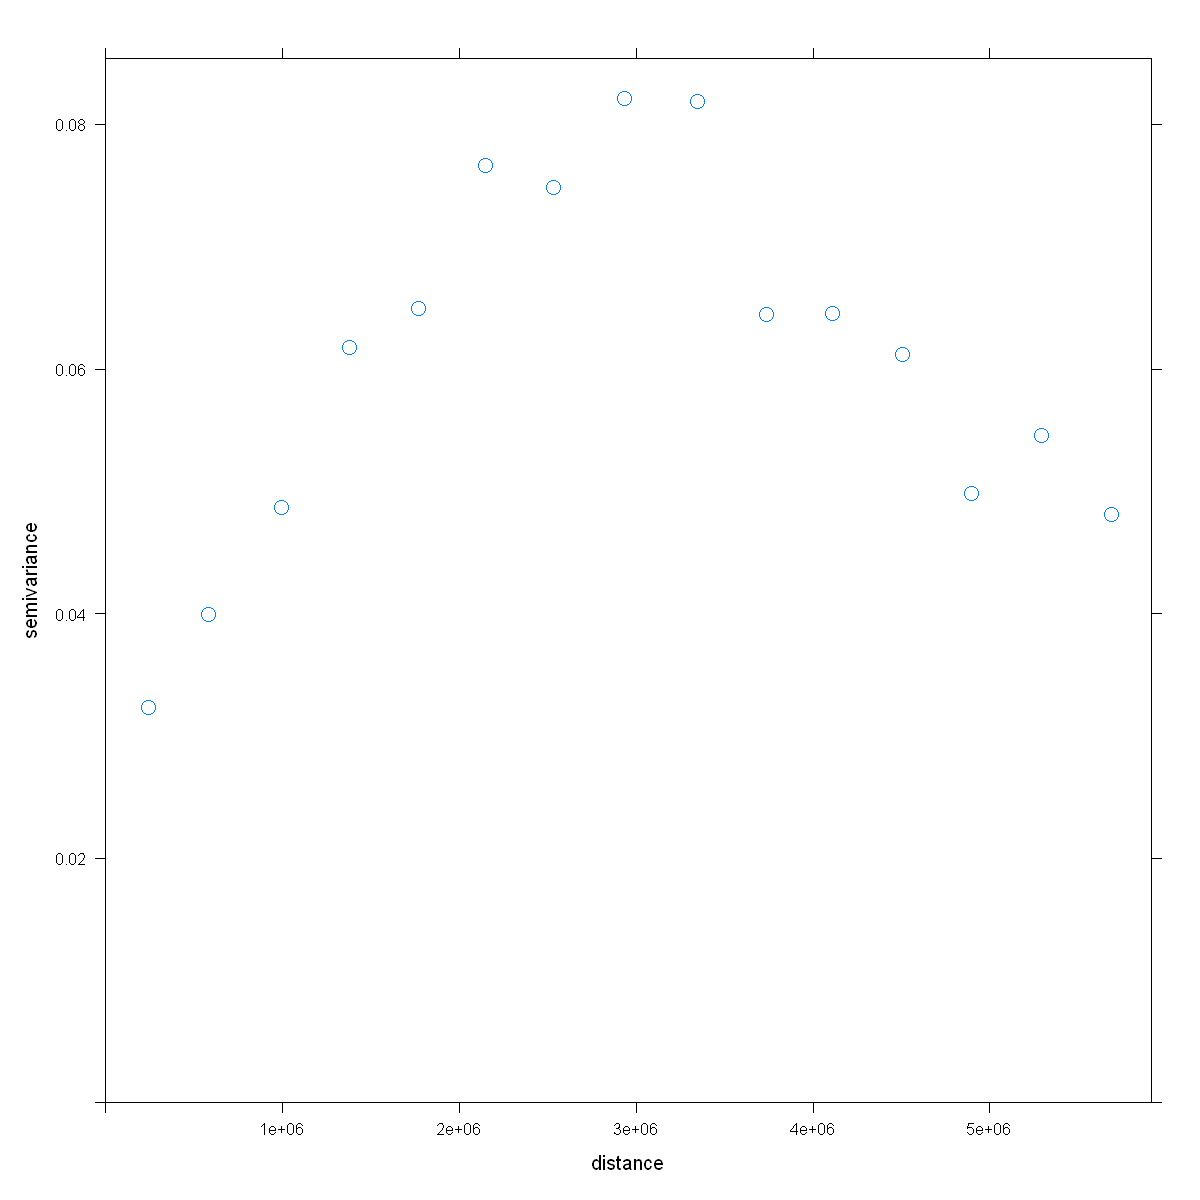

In [20]:
options(repr.plot.width=10, repr.plot.height=10)
# create a variogram...
geodata_vgm = variogram(r ~ 1, geodata_sf)
# ...and plot it
plot(geodata_vgm, cex = 1.5)

Looking at this, a sensible cutoff point (maximum distance to where point pairs are considered) looks to be at a distance of 1.5 million. 

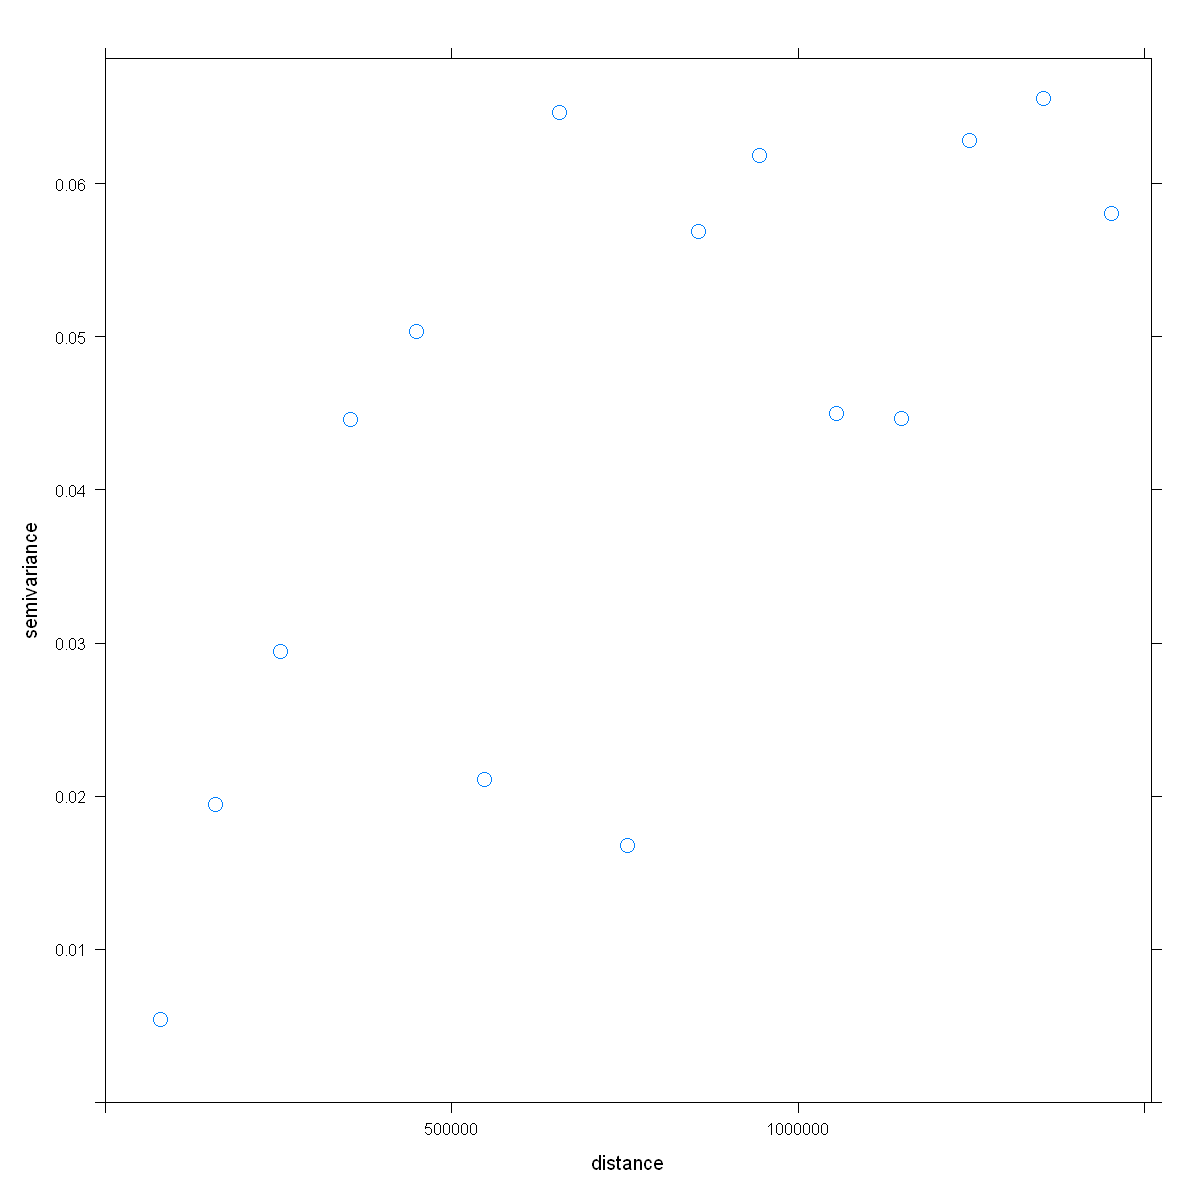

In [21]:
# create variogram again, but with a custom cutoff
geodata_vgm = variogram(r ~ 1, geodata_sf, cutoff=1500000)
plot(geodata_vgm, cex = 1.5)

Next up a fitting model needs to be selected. Trial & error does the trick and a exponential kernel with a *psill* of 0.12 seems to fit the data pretty well.

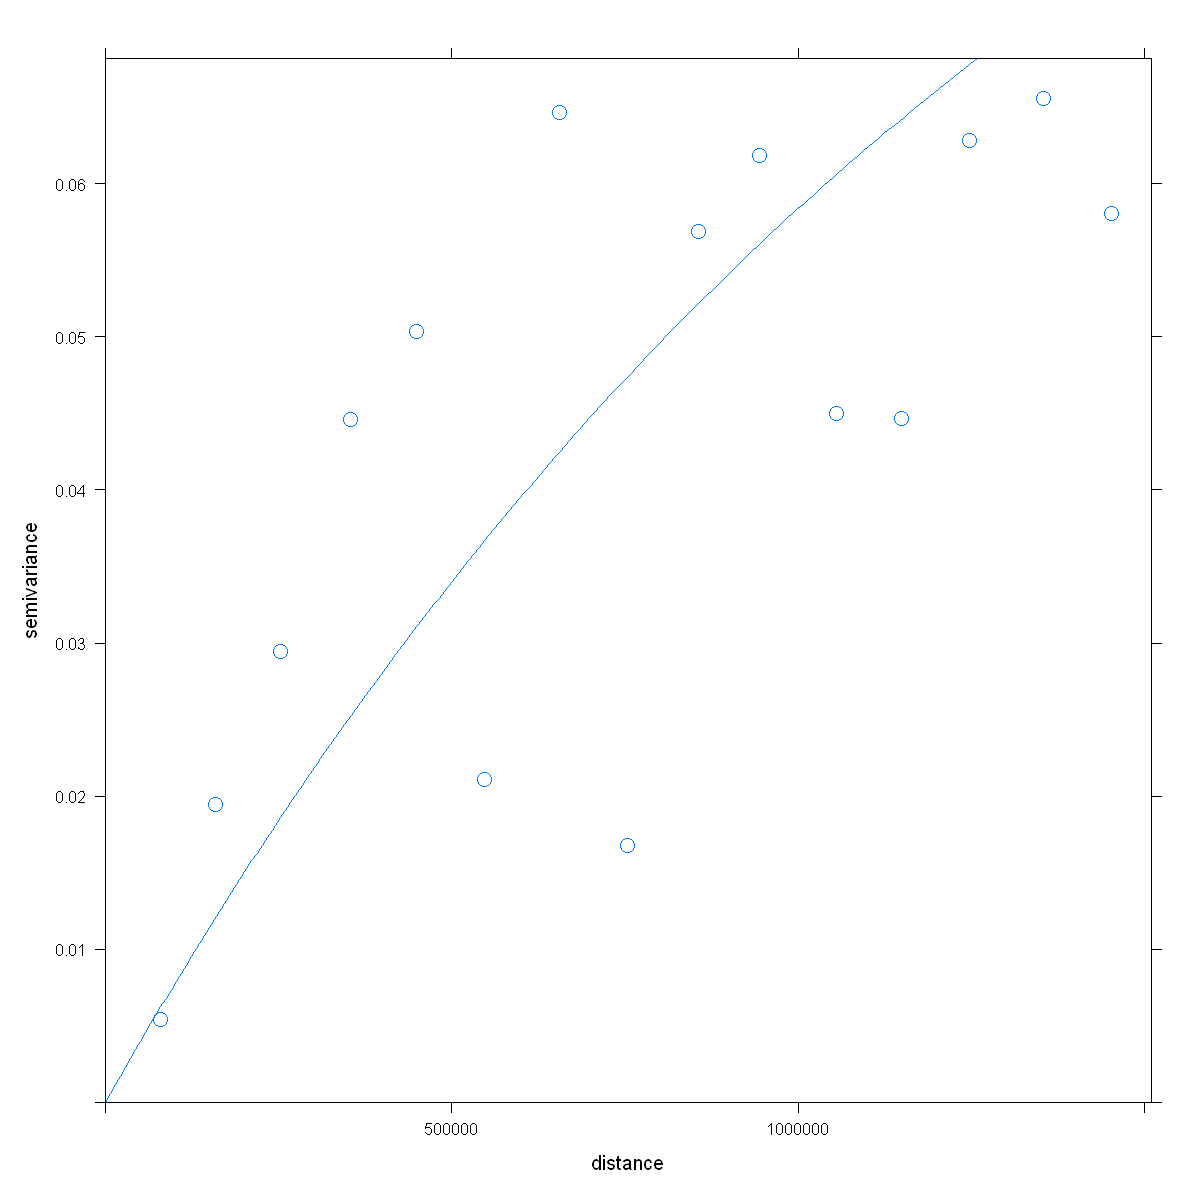

In [22]:
model = vgm(psill=0.12, "Exp", range=1500000)
plot(geodata_vgm, model, cex = 1.5, lwd= 1.5)

Content with the selected model, it can then be fitted.

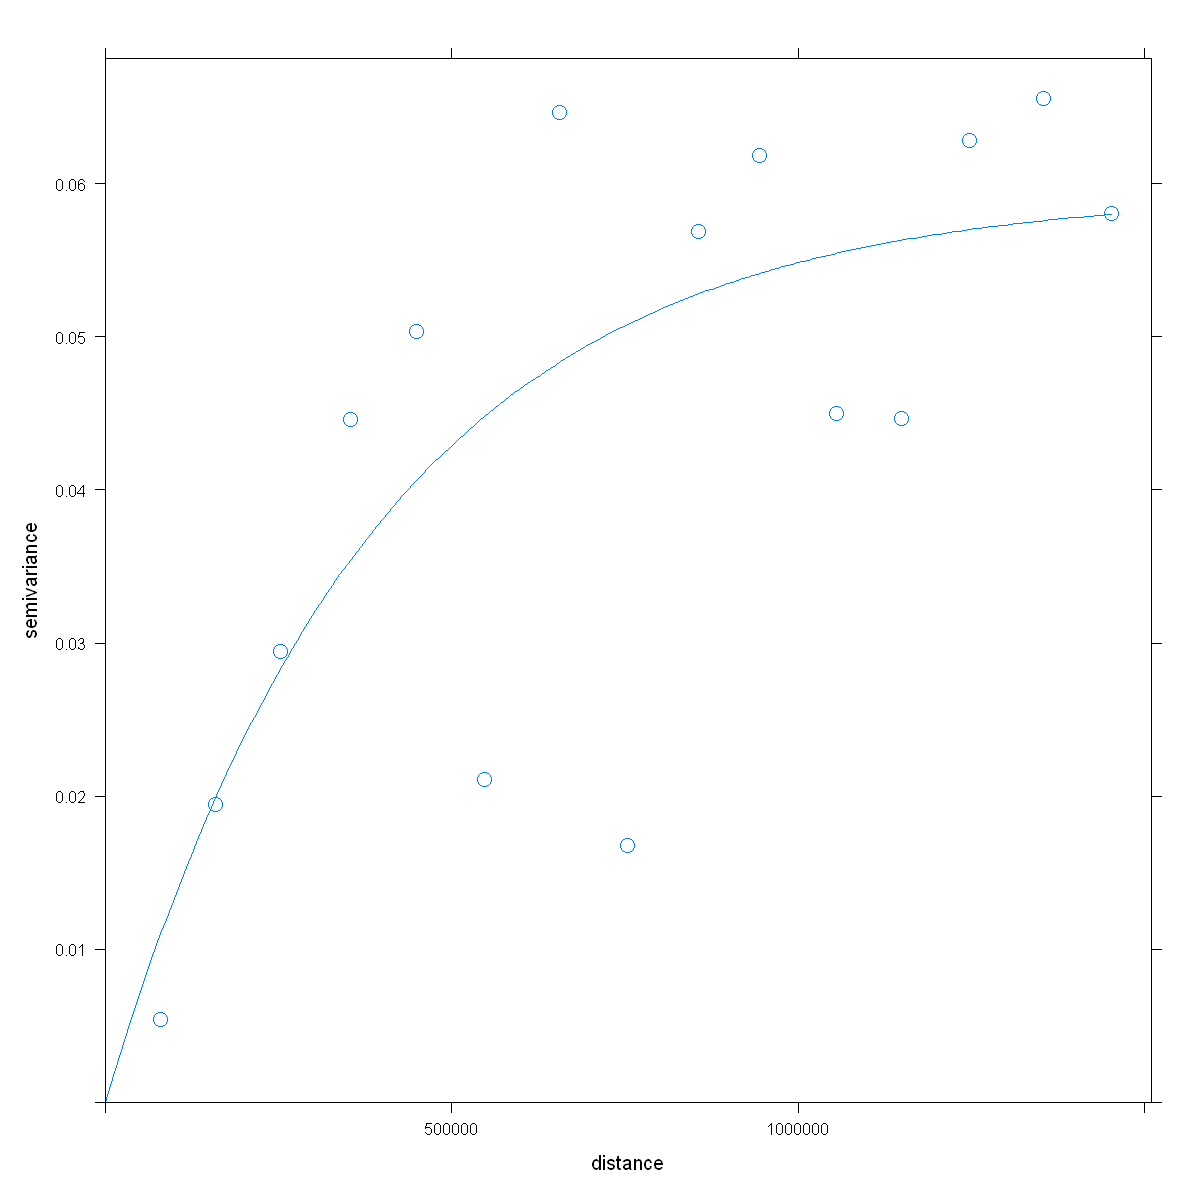

In [23]:
# fit the model...
vgm_fit = fit.variogram(geodata_vgm, model)
# ... and plot it with the variogram
plot(geodata_vgm, vgm_fit, cex = 1.5, lwd= 1.5)

With the fitted model the ordinary kriging can commence and the raster for the first dimension is finished.

[using ordinary kriging]


Warning message:
"PROJ: proj_as_wkt: Unsupported conversion method: Equal Earth (GDAL error 1)"
Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


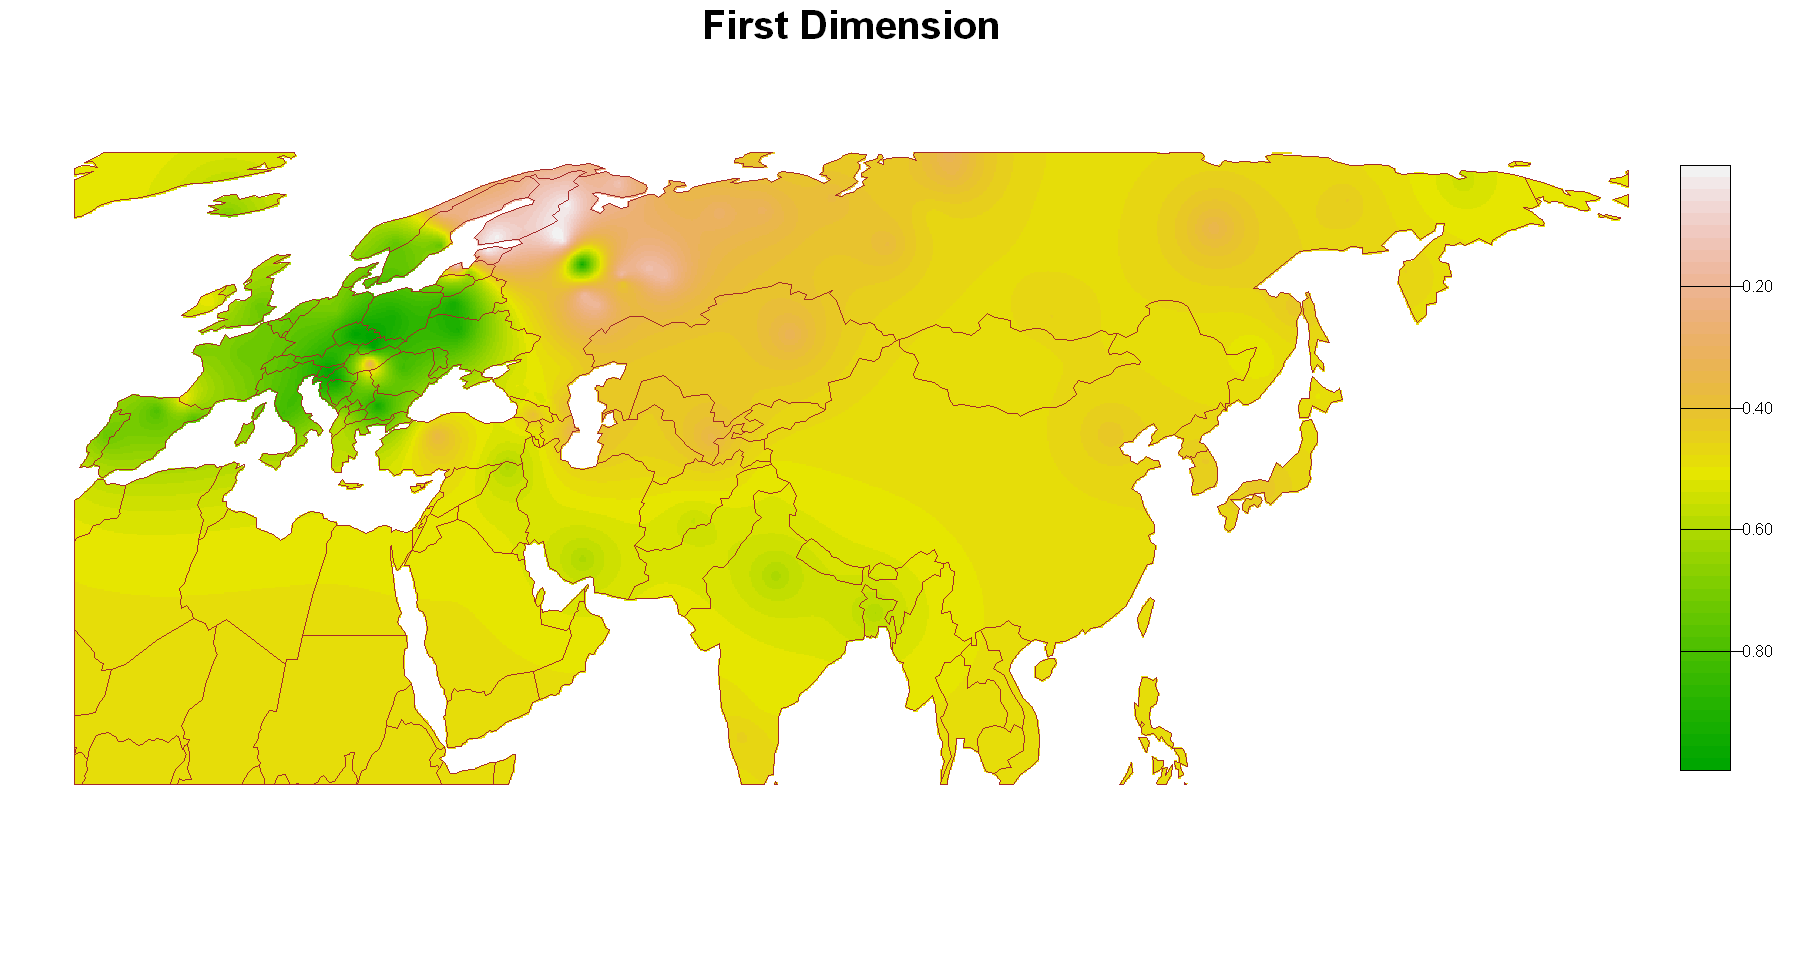

In [24]:
# do ordinary kriging
geodata_krigedR = krige(r ~ 1, geodata_sf, world_grid, model=vgm_fit)

# turn the kriging data into a SpatRaster
krigeR.raster = 
      geodata_krigedR %>%
      cbind(., st_coordinates(.)) %>%
      st_drop_geometry() %>%
      mutate(R = var1.pred) %>%
      dplyr::select(X, Y, R) %>%
      raster::rasterFromXYZ() %>%
      as("SpatRaster")

# filter the raster, so that predictions on the oceans / seas are ignored
filtered_raster = mask(krigeR.raster, vect(world_without_55)) 
# plot the raster
options(repr.plot.width=15, repr.plot.height=8)
eurasia = st_intersection(world_without_55, st_as_sfc(st_bbox(geodata_sf)))
plot(filtered_raster, axes=FALSE, legend=T, plg=list(shrink=0.66))
plot(st_geometry(eurasia), add=T, border="brown")
title("First Dimension", line=0.5, cex.main=2.0)

The process is then repeated for the 2nd and 3rd dimension. The *psill* and *cutoff* values vary for each dimension. 
___
Second Dimension

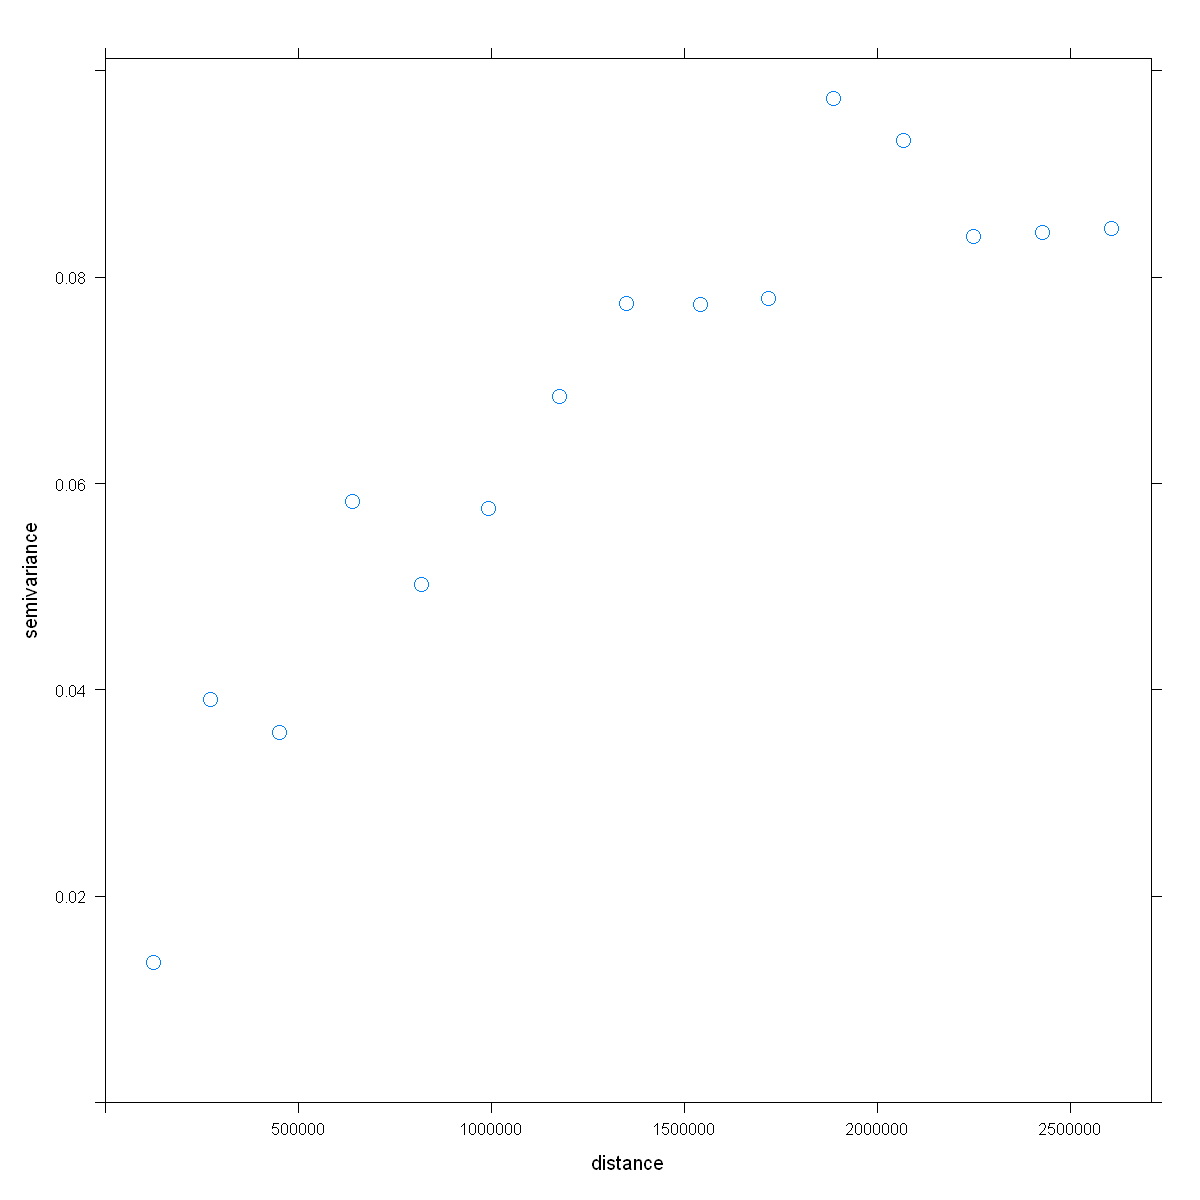

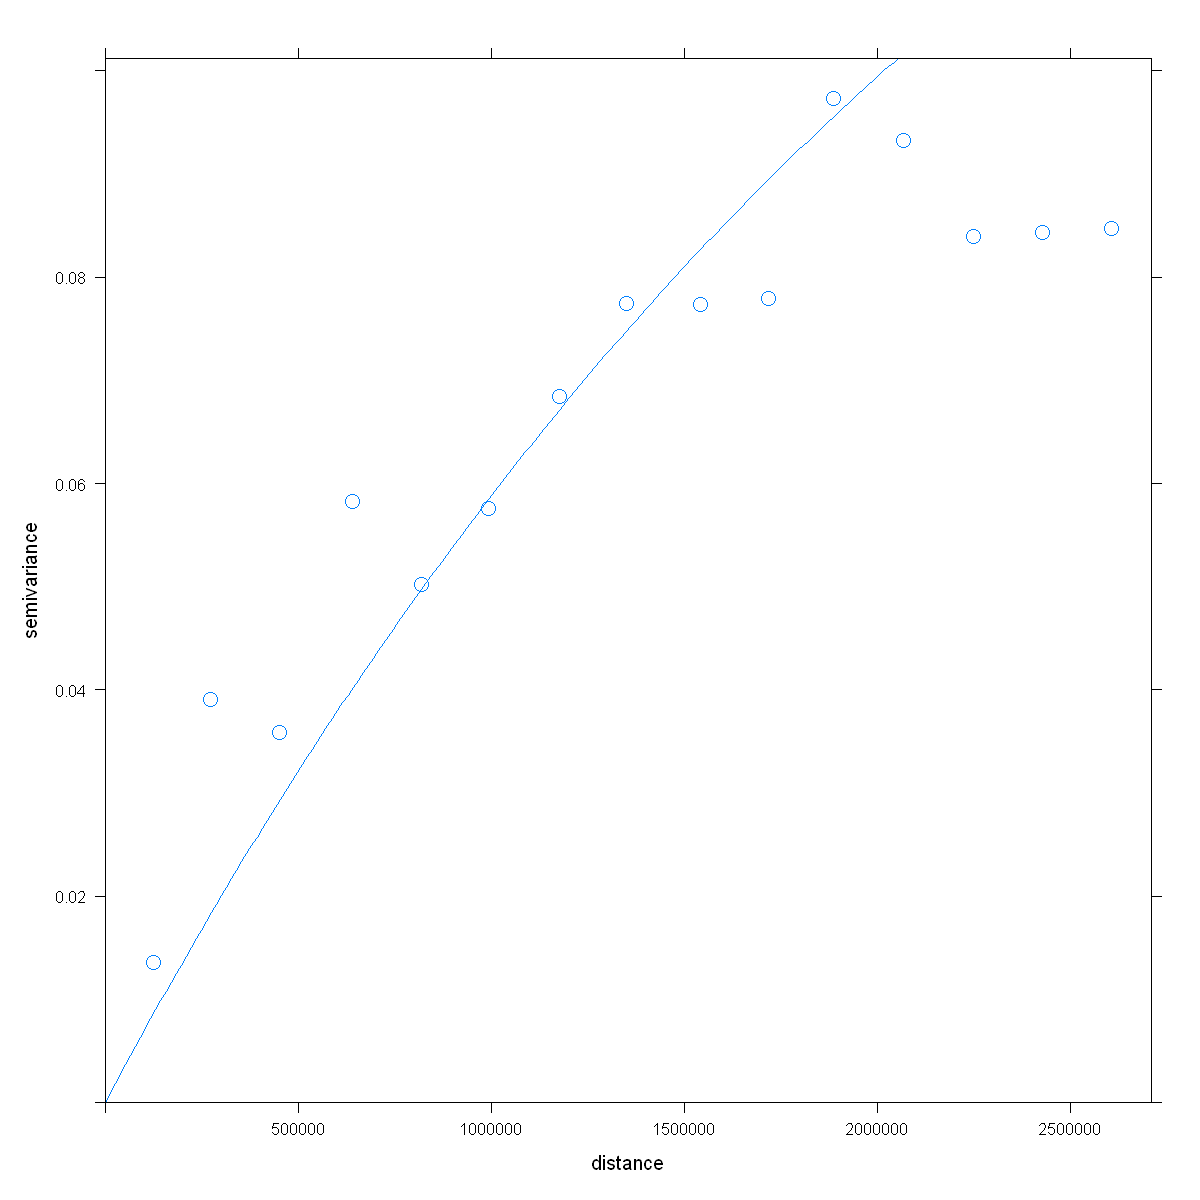

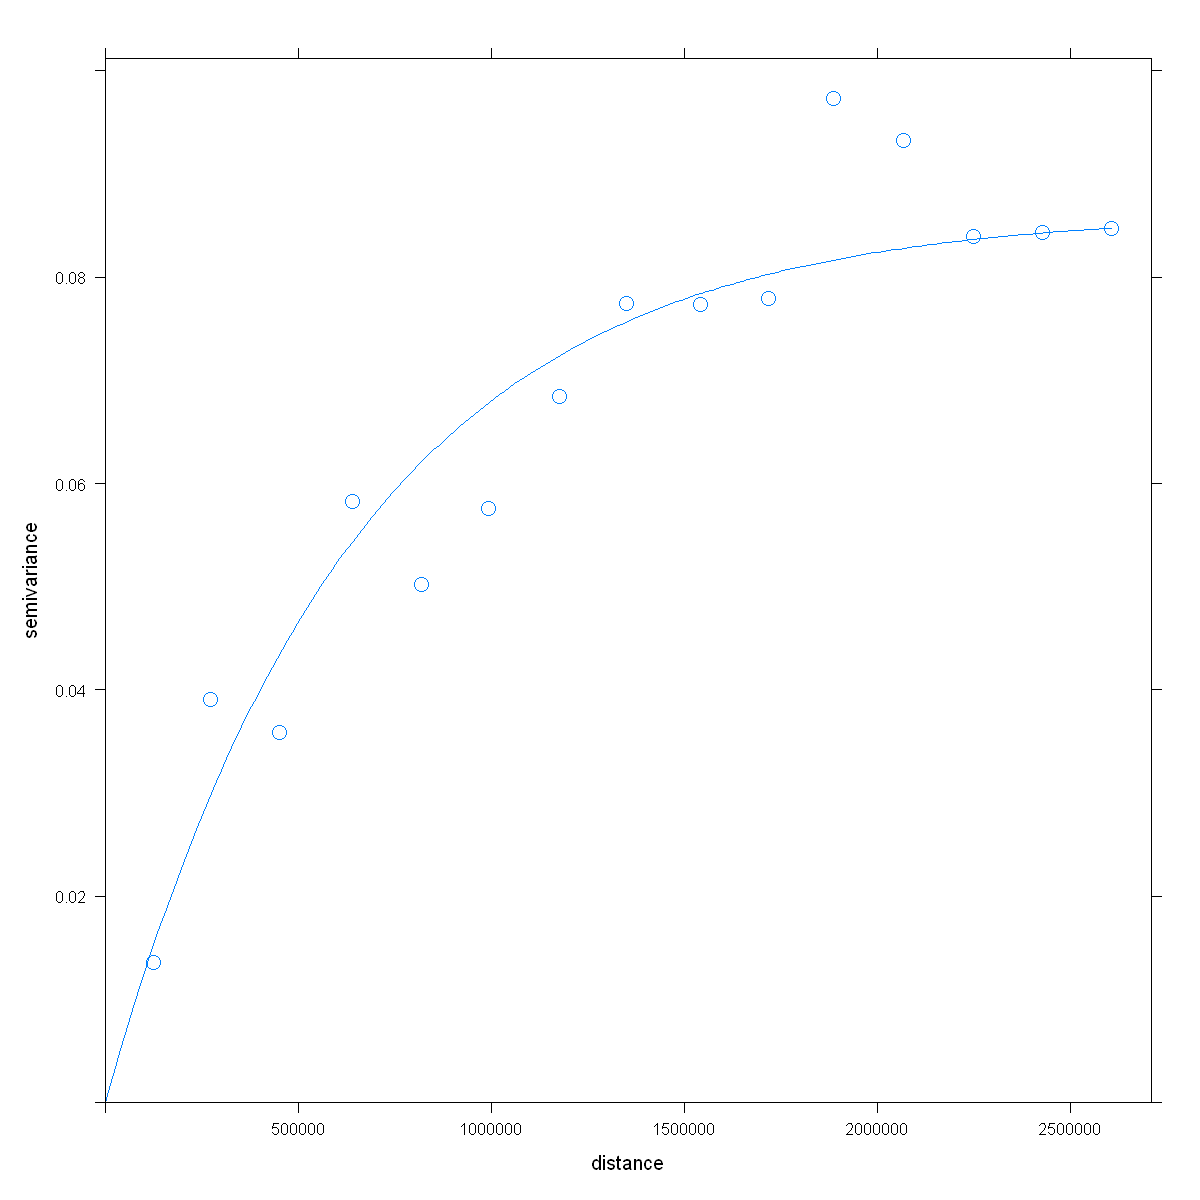

In [25]:
# variogram
geodata_vgm = variogram(g ~ 1, geodata_sf, cutoff=2700000)
options(repr.plot.width=10, repr.plot.height=10)
plot(geodata_vgm, cex = 1.5)

# variogram with proposed model
model = vgm(psill=0.19, "Exp", range=2700000)
plot(geodata_vgm, model, cex = 1.5, lwd= 1.5)

# variogram with fitted model
vgm_fit = fit.variogram(geodata_vgm, model)
plot(geodata_vgm, vgm_fit, cex = 1.5, lwd= 1.5)

[using ordinary kriging]


Warning message:
"PROJ: proj_as_wkt: Unsupported conversion method: Equal Earth (GDAL error 1)"


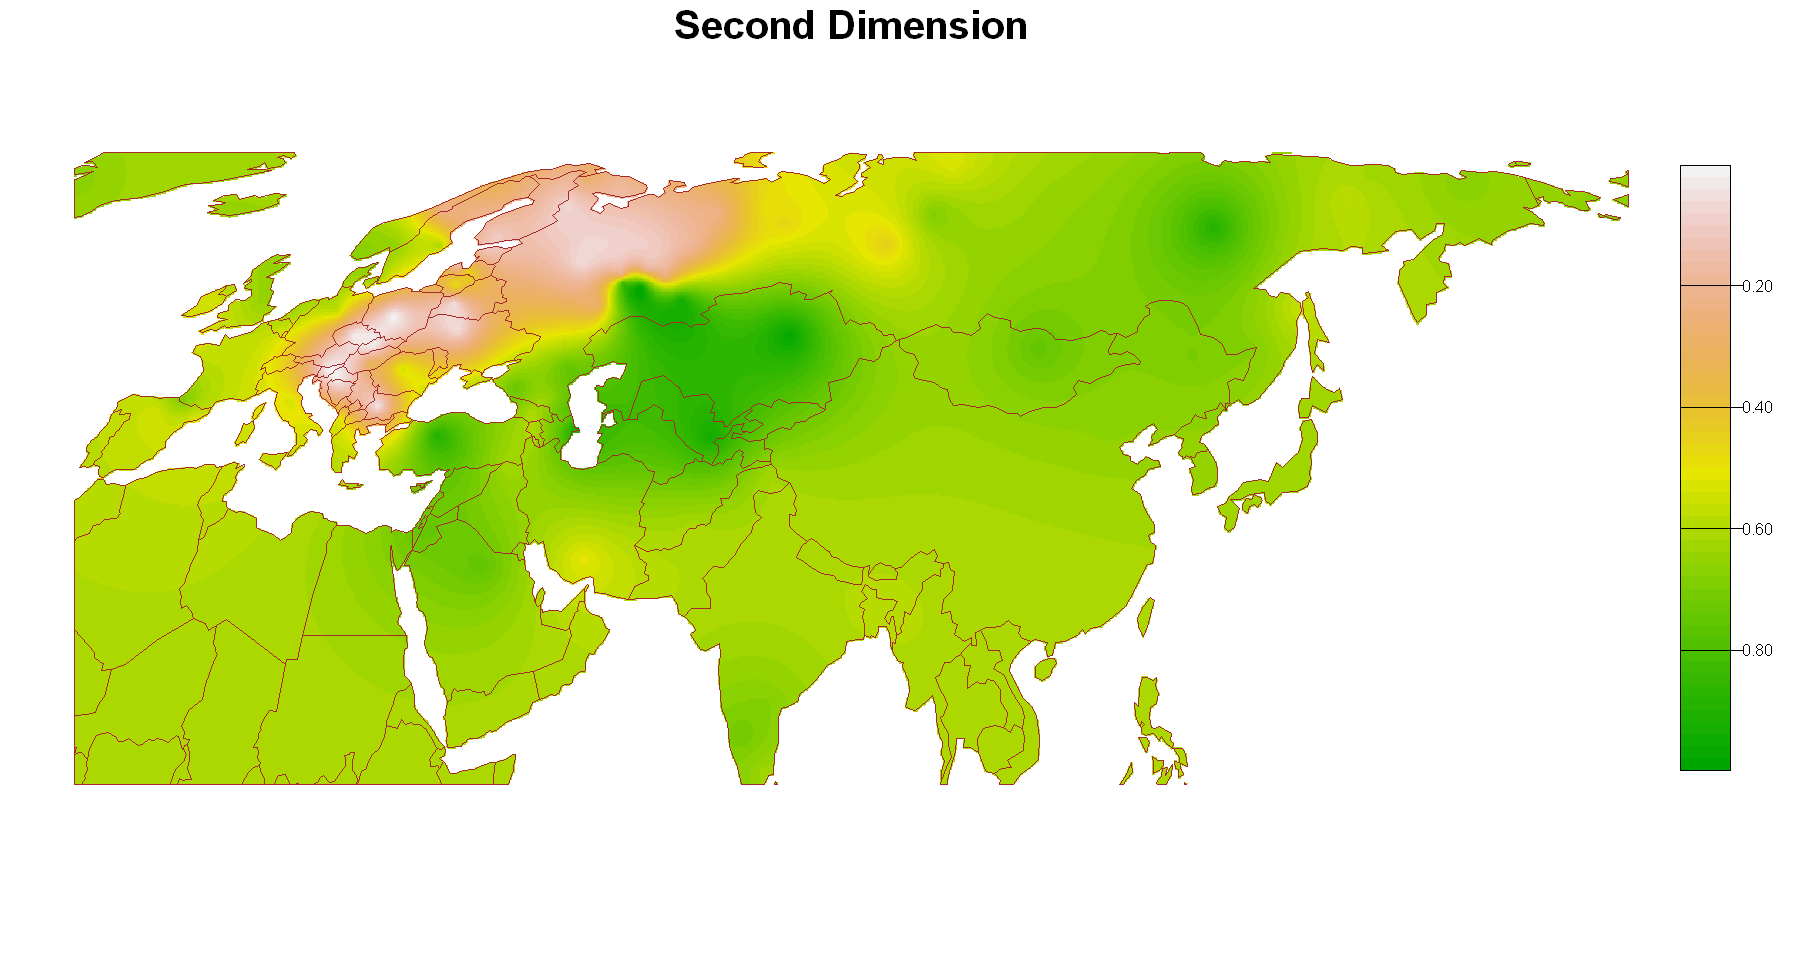

In [26]:
# do ordinary kriging
geodata_krigedG = krige(g ~ 1, geodata_sf, world_grid, model=vgm_fit)

# turn the kriging data into a SpatRaster
krigeG.raster = 
    geodata_krigedG %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(G = var1.pred) %>%
    dplyr::select(X, Y, G) %>%
    raster::rasterFromXYZ() %>%
    as("SpatRaster")

# filter the raster, so that predictions on the oceans / seas are ignored
filtered_raster = mask(krigeG.raster, vect(world_without_55)) 
# plot the raster
options(repr.plot.width=15, repr.plot.height=8)
plot(filtered_raster, axes=FALSE, legend=T, plg=list(shrink=0.66))
plot(st_geometry(eurasia), add=T, border="brown")
title("Second Dimension", line=0.5, cex.main=2.0)

___
Third Dimension

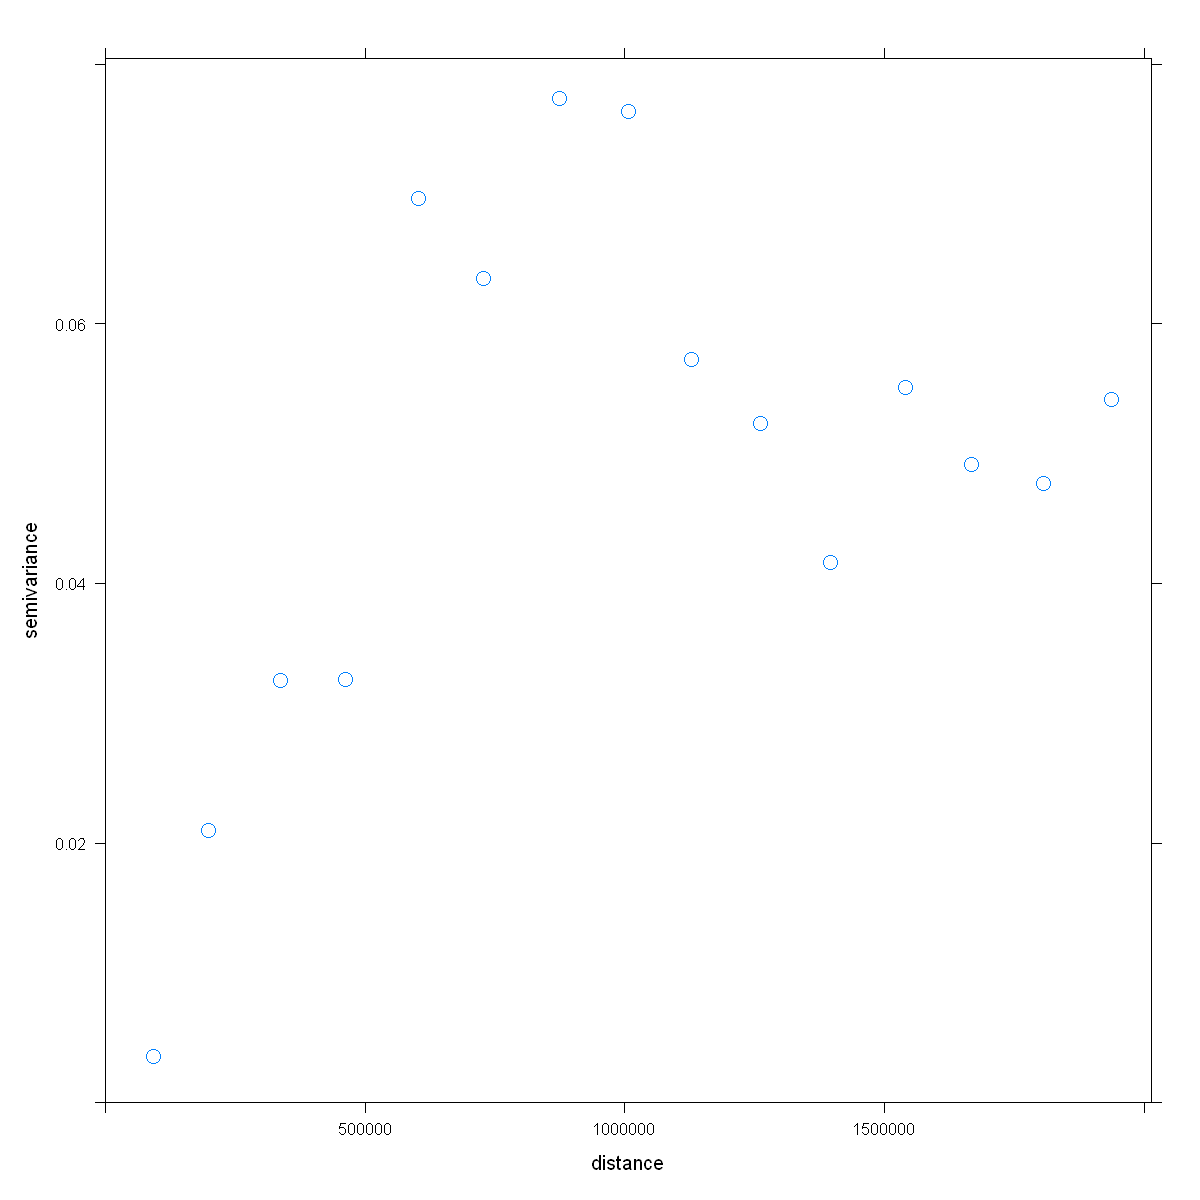

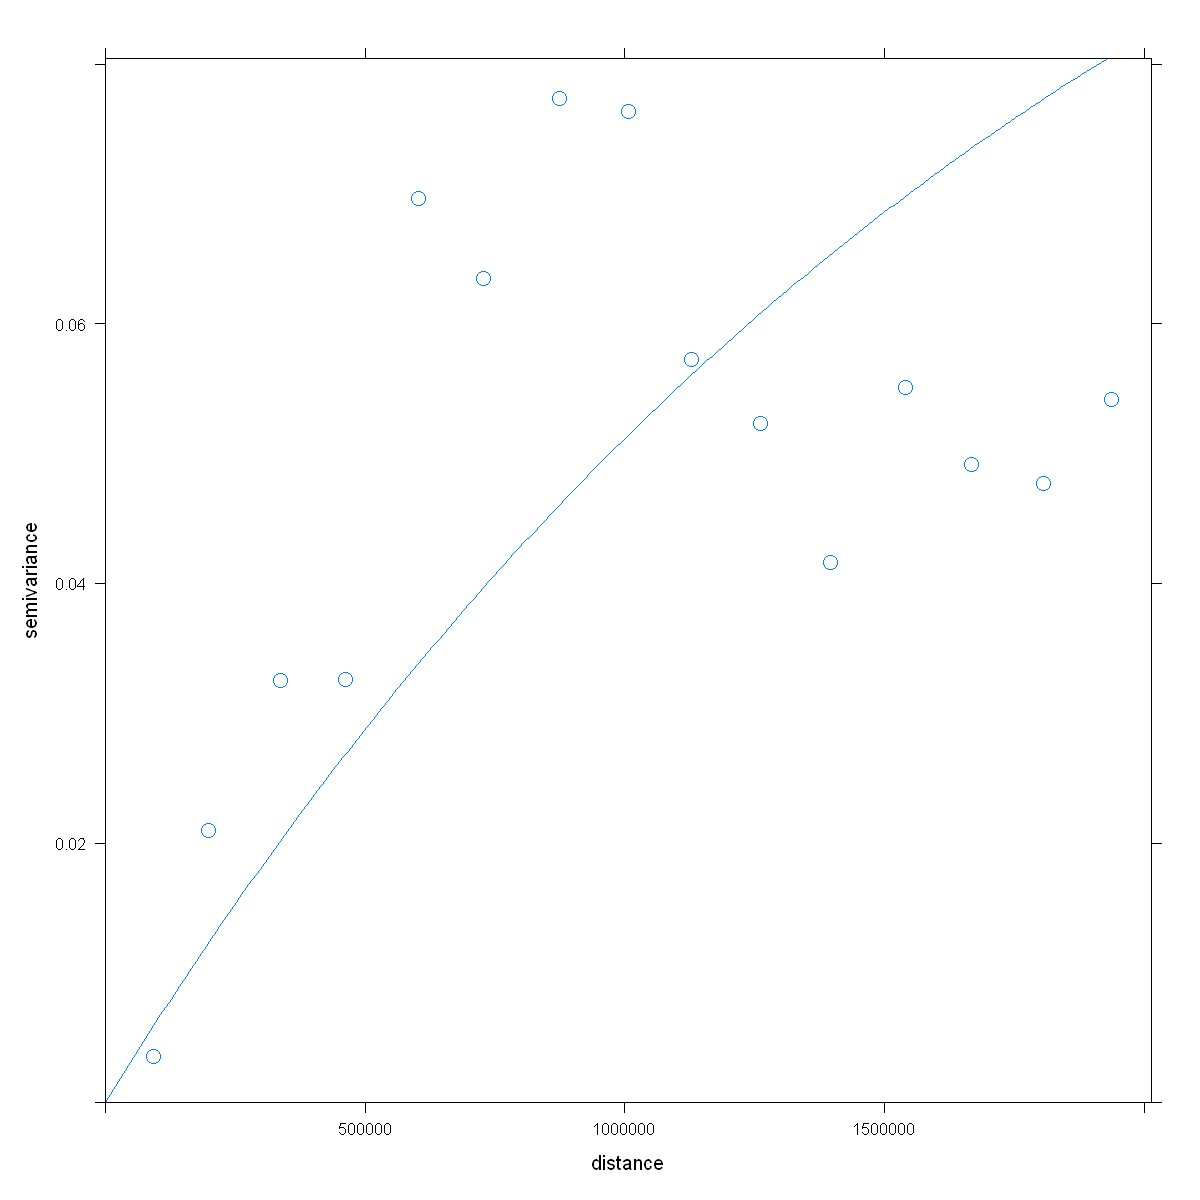

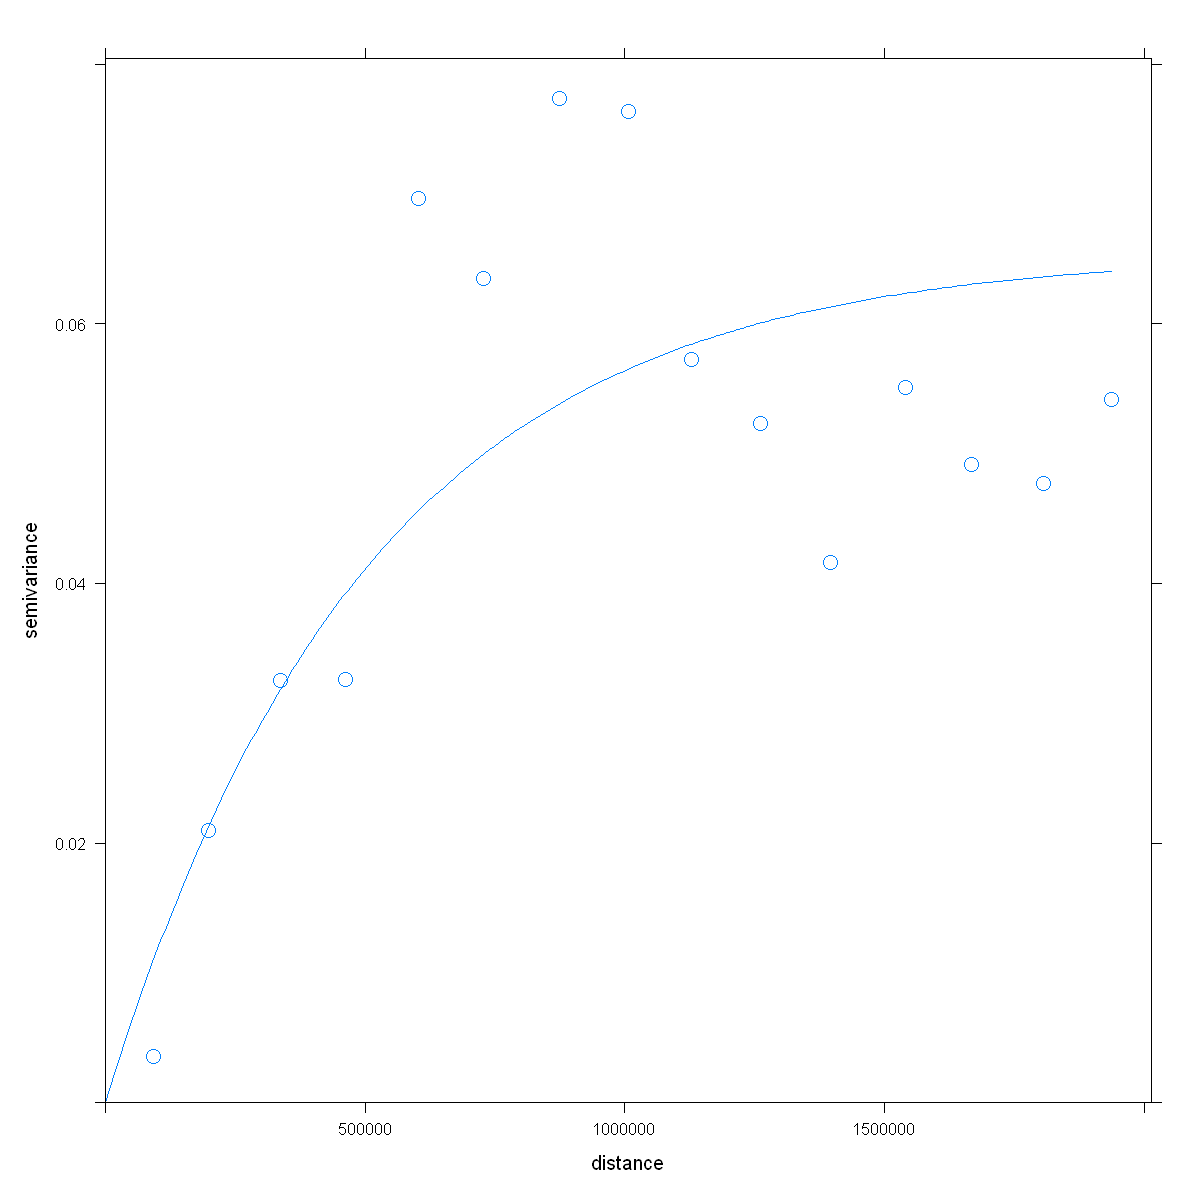

In [27]:
# variogram
geodata_vgm = variogram(b ~ 1, geodata_sf, cutoff=2000000)
options(repr.plot.width=10, repr.plot.height=10)
plot(geodata_vgm, cex = 1.5)

# variogram with proposed model
model = vgm(psill=0.13, "Exp", range=2000000)
plot(geodata_vgm, model, cex = 1.5, lwd= 1.5)

# variogram with fitted model
vgm_fit = fit.variogram(geodata_vgm, model)
plot(geodata_vgm, vgm_fit, cex = 1.5, lwd= 1.5)

[using ordinary kriging]


Warning message:
"PROJ: proj_as_wkt: Unsupported conversion method: Equal Earth (GDAL error 1)"


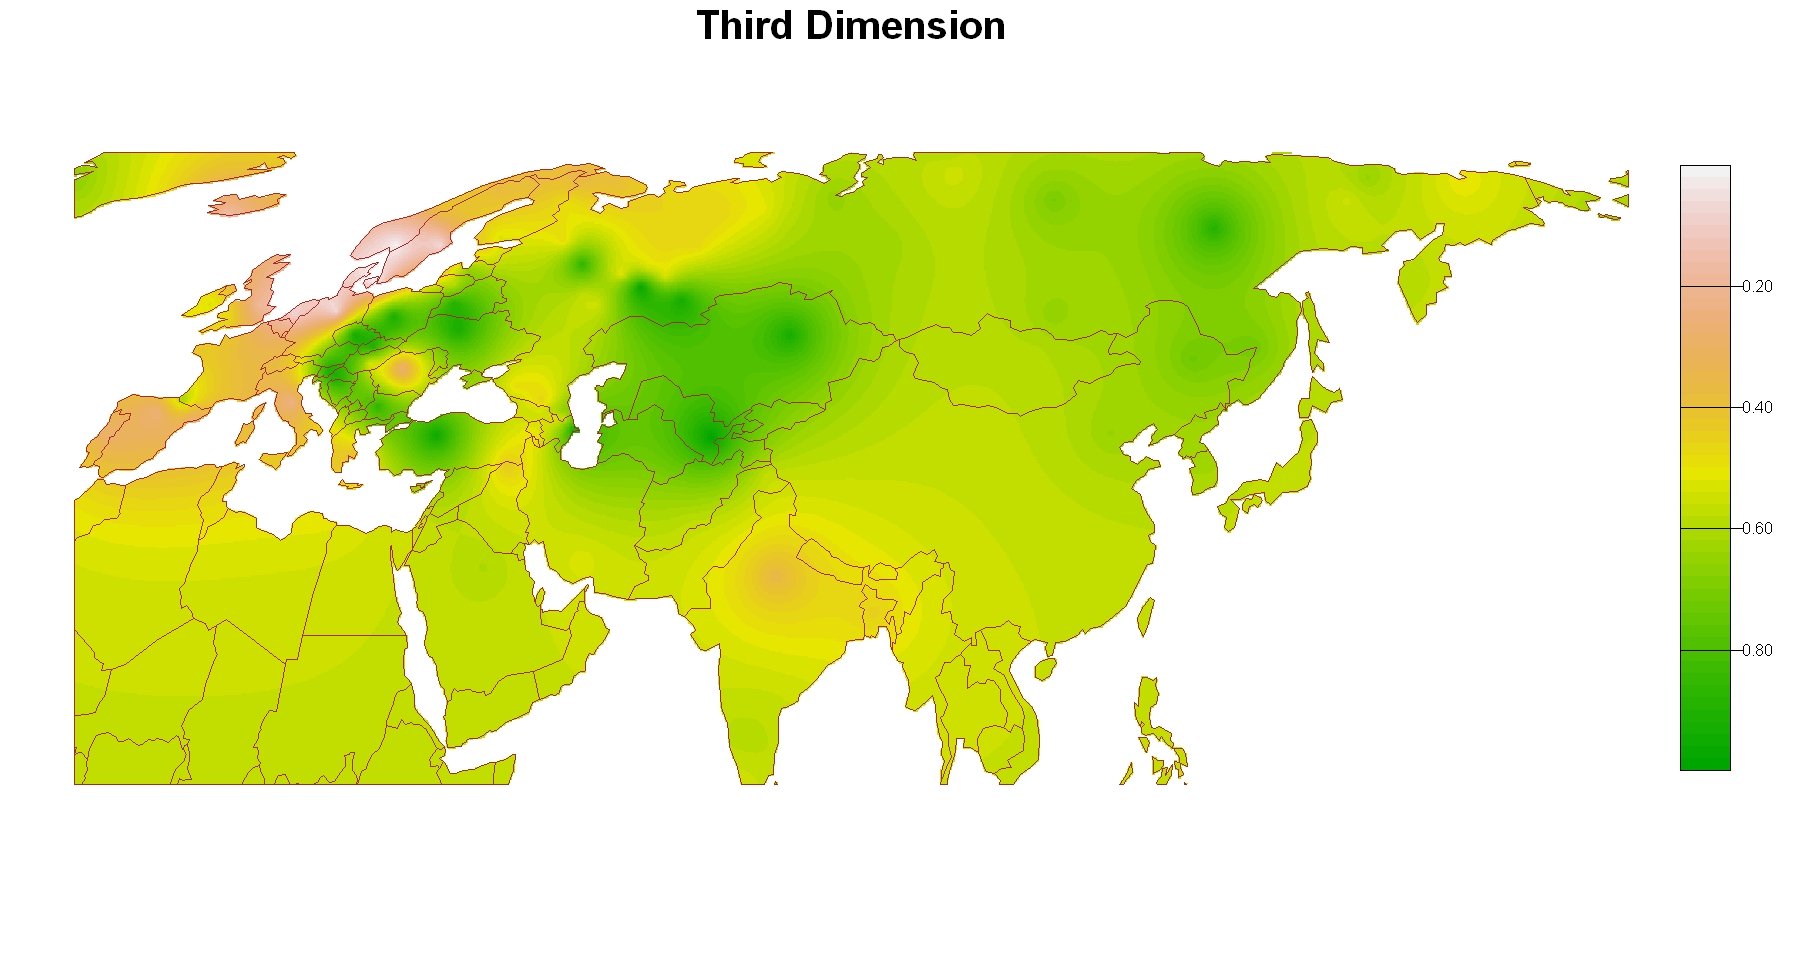

In [28]:
# do ordinary kriging
geodata_krigedB = krige(b ~ 1, geodata_sf, world_grid, model=vgm_fit)

# turn the kriging data into a SpatRaster
krigeB.raster = 
    geodata_krigedB %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(B = var1.pred) %>%
    dplyr::select(X, Y, B) %>%
    raster::rasterFromXYZ() %>%
    as("SpatRaster")

# filter the raster, so that predictions on the oceans / seas are ignored
filtered_raster = mask(krigeB.raster, vect(world_without_55)) 
# plot the raster
options(repr.plot.width=15, repr.plot.height=8)
plot(filtered_raster, axes=FALSE, plg=list(shrink=0.66))
plot(st_geometry(eurasia), add=T, border="brown")
title("Third Dimension", line=0.5, cex.main=2.0)

To visualize the three dimensions on one map, the values need to be scaled between 0 and 1 (because of the kriging some values are now below 0 or above 1).

In [29]:
# scale the values to be between 0 and 1
krigeR.raster = krigeR.raster - minmax(krigeR.raster)[1]
krigeR.raster = krigeR.raster / minmax(krigeR.raster)[2]

# repeat for 2nd dimension
krigeG.raster = krigeG.raster - minmax(krigeG.raster)[1]
krigeG.raster = krigeG.raster / minmax(krigeG.raster)[2]

# repeat for 3rd dimension
krigeB.raster = krigeB.raster - minmax(krigeB.raster)[1]
krigeB.raster = krigeB.raster / minmax(krigeB.raster)[2]

Then a raster consisting of the three previous rasters can be constructed and plotted subsequently.

Warning message:
"PROJ: proj_as_wkt: Unsupported conversion method: Equal Earth (GDAL error 1)"


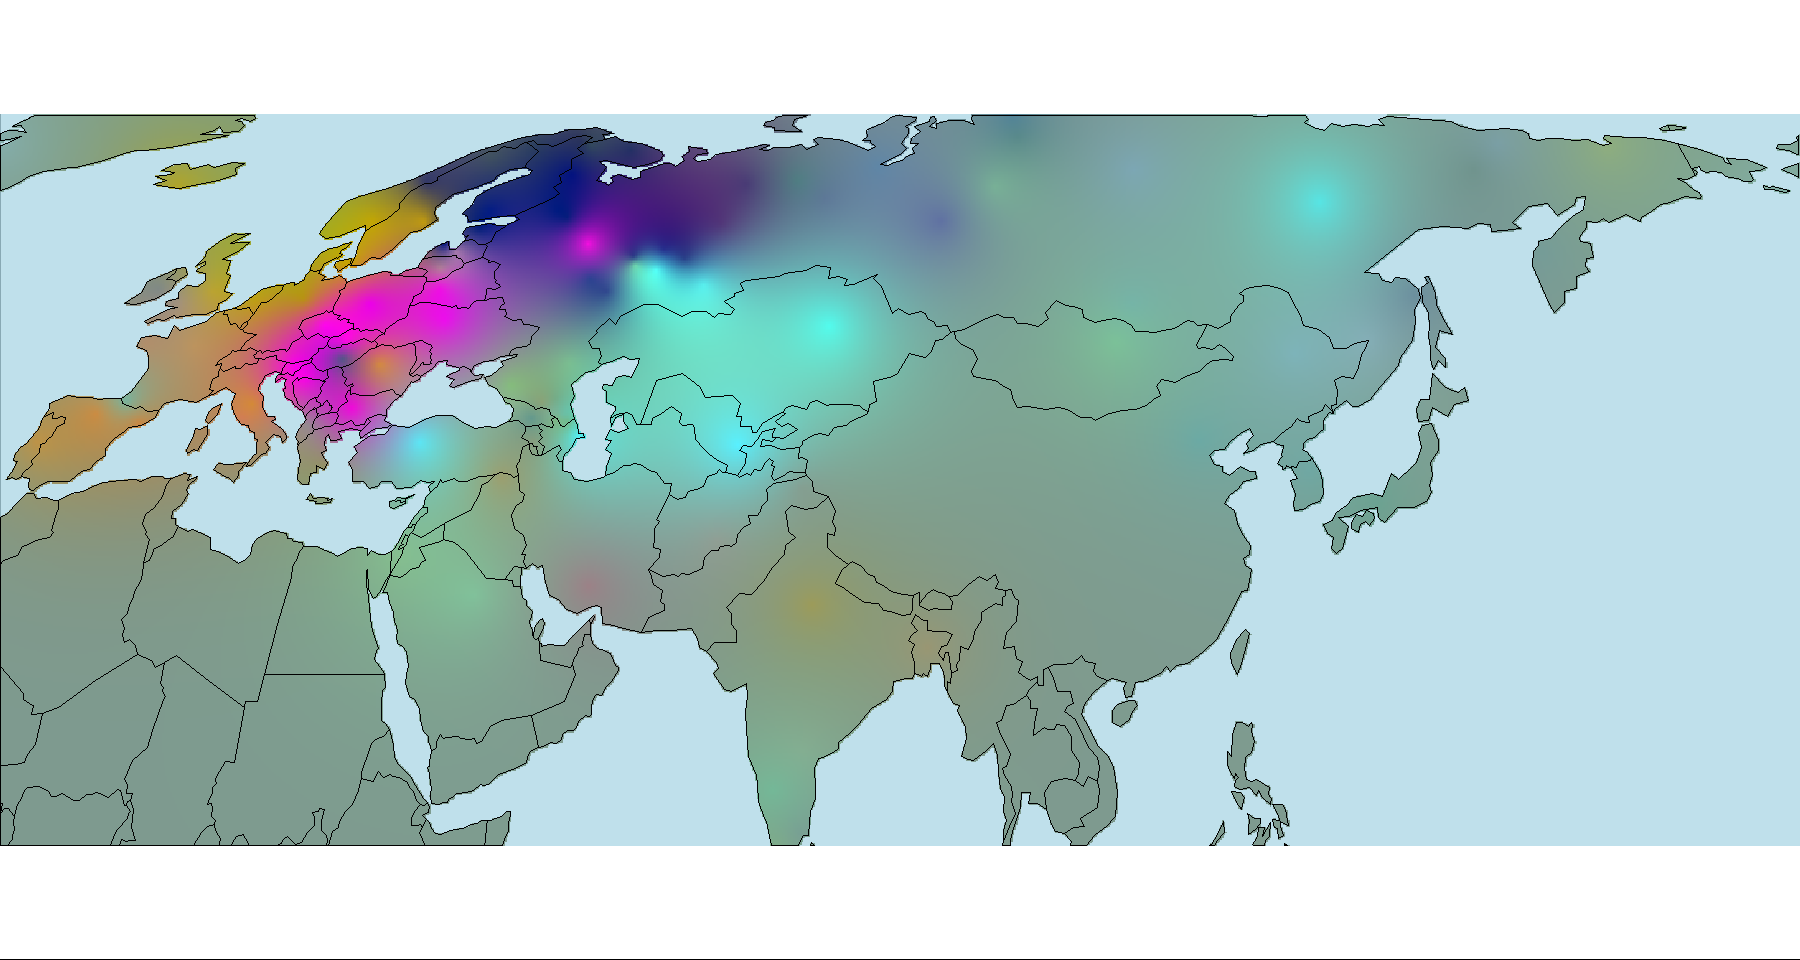

In [30]:
# adapting the plot window for the last two plots
krigeRGB.raster = c(krigeR.raster, krigeG.raster, krigeB.raster)
filtered_raster = mask(krigeRGB.raster, vect(world_without_55)) 
plotRGB(filtered_raster, axes=T, scale=1, colNA="lightblue", alpha=1, bgalpha=200)
plot(st_geometry(eurasia), add=T, border="black")

For a smoother map where the original points are less prominent, generalized additive models can be applied. 

The procedure there is to fit a generalized model on each of the dimensions, making predictions with these models and then creating rasters based on those predictions.

In [31]:
# fit a model
gam.fit = 
    geodata_sf %>%
    cbind(., st_coordinates(.)) %>%
    select(r, X, Y) %>%
    mgcv::gam(r ~ s(X,Y), data=.)

# make predictions with the model
gam.prediction = predict(gam.fit, newdata = data.frame(st_coordinates(world_grid)))

# create a raster based on the model predictions
gamR.raster =
    geodata_krigedR %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = gam.prediction) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Repeat with the 2nd dimension.

In [32]:
gam.fit =
    geodata_sf %>%
    cbind(., st_coordinates(.)) %>%
    select(g, X, Y) %>%
    mgcv::gam(g ~ s(X,Y), data=.)


gam.prediction = predict(gam.fit, newdata = data.frame(st_coordinates(world_grid)))

gamG.raster =
    geodata_krigedG %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = gam.prediction) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

And the same with the 3rd dimension.

In [33]:
gam.fit =
    geodata_sf %>%
    cbind(., st_coordinates(.)) %>%
    select(b, X, Y) %>%
    mgcv::gam(b ~ s(X,Y), data=.)


gam.prediction = predict(gam.fit, newdata = data.frame(st_coordinates(world_grid)))

gamB.raster =
    geodata_krigedB %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = gam.prediction) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Then the same value-scaling takes place, as it did earlier for the kriging rasters.

In [34]:
# scale the values to be between 0 and 1
gamR.raster = gamR.raster - minmax(gamR.raster)[1]
gamR.raster = gamR.raster / minmax(gamR.raster)[2]

# repeat for 2nd dimension
gamG.raster = gamG.raster - minmax(gamG.raster)[1]
gamG.raster = gamG.raster / minmax(gamG.raster)[2]

# repeat for 3rd dimension
gamB.raster = gamB.raster - minmax(gamB.raster)[1]
gamB.raster = gamB.raster / minmax(gamB.raster)[2]

Finally, a raster that combines the three dimensions is built. Using generalized additive models results in a significantly smoother map. Thus the map also conceals local outliers, like the pink area in western russia, that is visible on the previously created kriging-based map. Therefore it might not always be desirable to use that approach, since the model - as the name implies - generalizes a lot. 

Warning message:
"PROJ: proj_as_wkt: Unsupported conversion method: Equal Earth (GDAL error 1)"


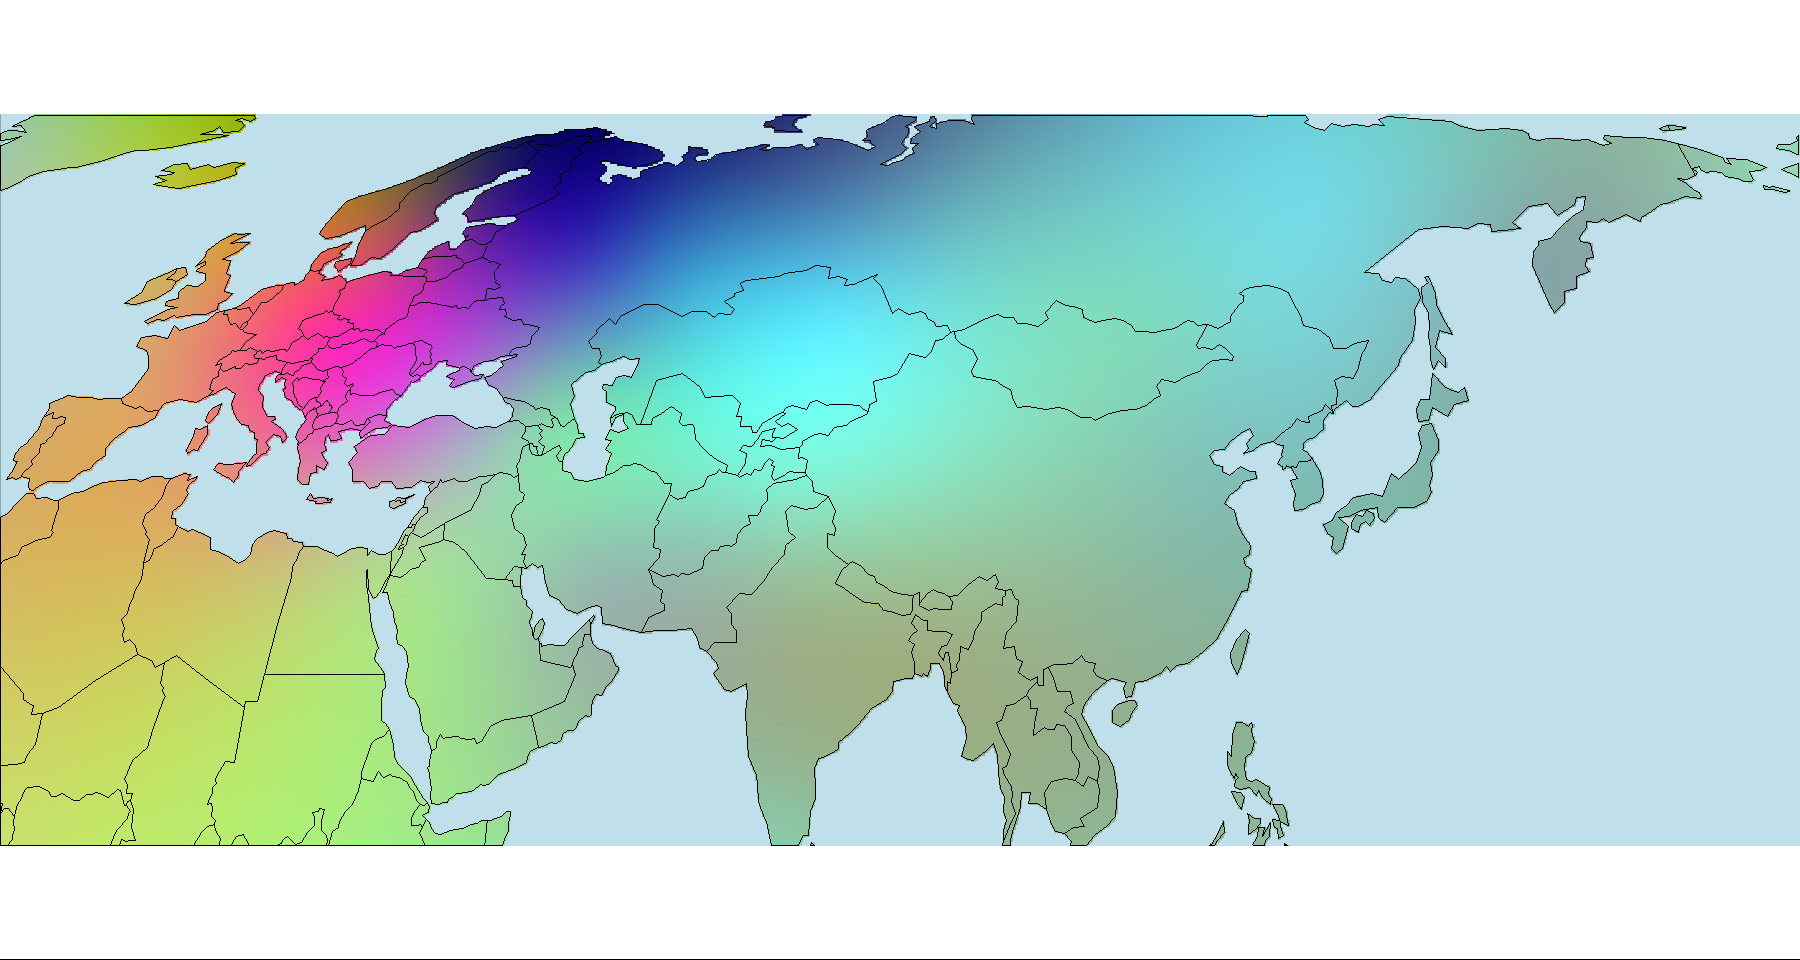

In [35]:
gamRGB.raster = c(gamR.raster, gamG.raster, gamB.raster)
filtered_raster = mask(gamRGB.raster, vect(world_without_55))
plotRGB(filtered_raster, axes=T, scale=1, colNA="lightblue", alpha=1, bgalpha=200)
plot(st_geometry(eurasia), add=T, border="black")

### References ###
- Brown, C., Holman, E., Wichmann, S. & Velupillai, V. (2008). Automated classification of the world′s languages: a description of the method and preliminary results. Language Typology and Universals, 61(4), 285-308. https://doi.org/10.1524/stuf.2008.0026
- Dellert, J., &amp; Jäger, G. (n.d.). Lexicostatistical database of Northern Eurasia. NorthEuraLex. Retrieved April 28, 2022, from http://www.northeuralex.org/ 
- Holman, E. W., Wichmann, S., Brown, C. H., Velupillai, V., Müller, A., & Bakker, D. (2008). Explorations in automated language classification.
- Swadesh, M. (1955). Towards Greater Accuracy in Lexicostatistic Dating. International Journal of American Linguistics, 21(2), 121-137. http://www.jstor.org/stable/1263939